# **Modèle du jeu "Qui suis-je ?" avec TF agents**

Nous proposons ici un modele de TF-agents pour jouer au célèbre jeu "Qui suis-je ?".

Nous nous sommes appuyé sur des exemples de modèle de TF-agent pour mettre en oeuvre d'autre type de jeu (Tic-Tac-Toe, Card, etc.).

Dans le jeu "de base", nous avons une table de 24 personnages.
2 joueurs s'affrontent pour découvrir un personnage.

Les personnages sont normalement étiquetés avec un nom unique.

Chaque joueur dispose de la même table visible de lui seul.

Chaque joueur tire au hasard une carte parmi tous les personnages (ou choisi un personnage exclusif) sans le montrer à son adversaire.

Chaque joueur doit découvrir le personnage de l'autre joueur en procédant par élimination. Pour cela, chaque joueur doit poser à tour de rôle une question pertinente  (en fonction de sa "main courante" ou sous-ensemble de personnages non encore éliminés) à l'autre joueur qui doit lui répondre sans mentir par 'Oui' ou 'Non'.

Sa question doit être vestimentaire ou lié à la physionomie et doit lui permettre de déterminer des sous-ensembles parmi la liste des personnages : "A-t-il les yeux bleus ?", "Porte-t-il un chapeau ?"... Il est interdit de poser deux fois la même question.

Lorsqu'un joueur n'a plus qu'une seule option, il doit annoncer à l'autre joueur le nom du personnage de son adversaire. Si le nom annoncé est bien celui de l'autre joueur, celui a gagné la partie,  mais si il s'est trompé, il a perdu la partie.

Si un joueur a éliminé tous les personnages possibles (plus de personnages potentiel de l'autre joueur) il a perdu la partie.

Il existe déjà des théories mathématiques sur le jeu. Celles-ci offrent généralement une approche sous forme de calculs probabilistes sur les chances de gagner, mettent en avant la combinatoire de questions. Quelques unes ont été rappelées ici dans les sources.

Notre version dépasse le cadre du jeu "de base" car nous allons utiliser d'autres capacité fournient par l'IA (entrainement d'agents dynamiques concurrents, reconnaissance d'image et modèles de langage), pour être capable d'appliquer ce type de jeu à :
- un nombre paramétrable de personnages (plus grand ou plus petit que le jeu de base)
- n'importe quelle photo de personnages dans une scéne
(on peut donc jouer par exemple avec une photo de famille si on le souhaite)

Hors le côté "pratique" de ce jeu, L'intérêt de ce jeu est multiple :
- Definir une théorie des questions éliminatoires autour d'une sequence de question non combinatoire "optimum" pour déterminer le plus efficacement possible un individu dans un groupe (stratégie d'interrogatoire pour retrouver des personnes disparues plus rapidement, etc.)

Pour aller plus loin :
- Développer un modèle sur le "facteur de mensonge" pour mieux tenir compte du fait que l'adversaire peut mentir à une question.


Notre cas pratique est décomposé en deux parties :
- Une première partie est la production des données de base (que l'on peut considérer comme nos datasets) qui serviront pour notre modèle.
- Une seconde partie est l'élaboration et l'entrainement du modèle lui-même

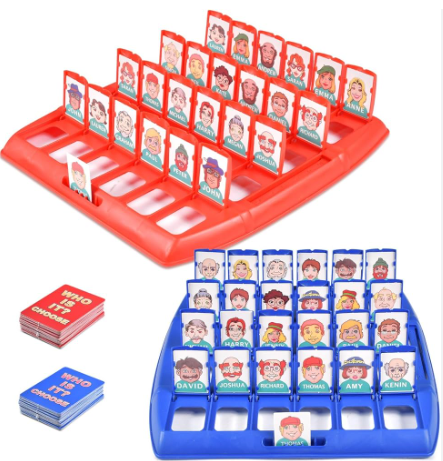

Sources :
* COMMENT GAGNER AU JEU «QUI EST-CE?»: GRÂCE AUX MATHÉMATIQUES, Pierre-Luc Racine, 16 mars 2020, https://urbania.fr/article/comment-gagner-au-jeu-qui-est-ce-grace-aux-mathematiques
* Optimal Strategy in “Guess Who?”: Beyond Binary Search, Mihai Nica, January 19, 2016, https://arxiv.org/pdf/1509.03327

Note : Les images sont utilisées ici uniquement à titre d'exemples pour nos tests IA. Nous nous sommes normalement assuré qu'elles étaient libres de droit. Si nous avions commis malgré tout une erreur en les utilisant merci de nous en informer. A noter, que certaines font déjà parties de dataset d'images IA existants.

 📌 **Please note that the text of this colab has been written in french. Use Google Traduction if you want the text in another language.**

# **1. Elaboration des données du jeu pour le modèle**

Dans cette partie, nous allons élaborer les données d'entrées du jeu. A savoir :
les personnages du jeu, les questions à poser et les réponses attendues pour chaque personnage.
Nous allons également mettre en place les fonctions de base qui serviront pour l'environnement du jeu. Par exemple, une fonction qui retournera la réponse à une question sur un personnage ou un sous-ensemble de personnages du jeu.
Ici, on ne va pas "réinventer la roue". On s'appuiera sur les frameworks et les modèles IA pré-entraîné existants qui réalisent le type de tâche demandé très bien déjà : TensorFlow et Keras, PyTorch, Hugging Face et ensemble de pipelines et modèles existants.



De manière générale, nous recommandons l'utilisation du GPU pour les performances dans Colab (ou autre) => Activez-le dans votre session.:

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device == torch.device('cuda'), "Not using CUDA. Set: Runtime > Change runtime type > Hardware Accelerator: GPU"

**1. Mise à jour de la configuration pour l'élaboration des données du modèle**

Nous supposons disposer dèjà d'une configuration Colab "de base" avec Numpy, Pytorch, TensorFlow. Cette configuration doit être mise à jour pour cette partie.

In [ ]:
!pip install -q insightface huggingface_hub onnxruntime tiktoken verovio easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 

**2. Définir la liste des questions du jeu**

Dans notre jeu, nous devons avoir une liste de questions fermées sur la physionomie ou ce qui se rapporte au vestimentaire d'une personne (réponse oui ou non uniquement). D'autres part, on se limitera à l'utilisation de questions simples non combinatoires (pas de "ou", "et"...).

A vrai dire, nous n'avons pas trouvé de données (ou datasets) existants avec la liste des questions typiques que l'on peut associer à notre jeu (mais peut-etre n'avons nous pas suffisamment cherché).

Aussi, nous avons établi notre propre liste très limitée de question que l'on pourra facilement étendre et compléter (n'hésitez pas à la compléter).

Nous avons classer nos questions par "thème" (yeux, bouche, etc.) et par variation (couleur, forme, etc.).

Comme nous sommes français, nous avons écrit cette liste en français.

Comme la plupart des modèles utilisés ensuite comprenne mieux l'anglais que le français, nous allons ensuite les traduire en anglais avec un pipeline "translation" de Hugging Face (c'est-à-dire une tâche prévu avec un modèle pré-entraîné NLP pour traiter ce type de problème, ici le modèle 'opus-mt-fr-en', Helsinki-NLP).

Nous allons découpé notre liste de questions en deux listes de question tirées aléatoirement par thème, une pour chaque joueur.

Ces listes seront exploitées dans la suite.

Notez que le jeu est borné par le nombre de questions disponibles : Le jeu s'arrêtera lorsqu'on a épuisé toutes nos questions.

Même si les questions combinatoires sont tolêrées dans le jeu de base (plusieurs questions en une, avec des "ou", des "et", questions sous forme négatives...), on se limitera volontarement ici à des questions simples pour le moment.

In [ ]:
# Question generation

from io import StringIO
import numpy as np
from transformers import pipeline
import random

#import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#assert device == torch.device('cuda'), "Not using CUDA. Set: Runtime > Change runtime type > Hardware Accelerator: GPU"

# Use a pipeline Hugging Face with a model for fr -> en translation
model_checkpoint = "Helsinki-NLP/opus-mt-fr-en"
fr_en_translator = pipeline("translation", model=model_checkpoint, device="cuda")

data_ended_question_on_person_fr_string= '''
# Theme de la question,Variation,Question
yeux,couleur,Est-ce qu'il a les yeux bleus ?
yeux,couleur,Est-ce qu'il a les yeux verts ?
yeux,couleur,Est-ce qu'il a les yeux gris ?
yeux,couleur,Est-ce qu'il a les yeux noirs ?
yeux,couleur,Est-ce qu'il a les yeux marrons ?
bouche,forme,Est-ce qu'il a la bouche ouverte ?
bouche,forme,Est-ce qu'il a la bouche carré ?
bouche,forme,Est-ce qu'il a la bouche ronde ?
bouche,forme,Est-ce qu'il a la bouche en forme d'ellipse ?
bouche,forme,Est-ce qu'il a la bouche en forme de pomme ?
bouche,forme,Est-ce qu'il a la bouche en forme d'arc ?
bouche,forme,Est-ce qu'il a la bouche en forme de ruban ?
bouche,forme,Est-ce qu'il a la bouche en forme de coeur ?
menton,forme,Est-ce qu'il a le menton pointu ?
menton,forme,Est-ce qu'il a le menton carré ?
menton,forme,Est-ce qu'il a le menton court ?
menton,forme,Est-ce qu'il a le menton rond ?
nez,forme,Est-ce qu'il a le nez pointu ?
nez,forme,Est-ce qu'il a le nez droit ?
nez,forme,Est-ce qu'il a le nez concave ?
nez,forme,Est-ce qu'il a le nez d'oiseau ?
nez,forme,Est-ce qu'il a le nez convexe ?
nez,forme,Est-ce qu'il a le nez nubien ?
nez,forme,Est-ce qu'il a le nez plat ?
nez,forme,Est-ce qu'il a le nez retroussé ?
nez,forme,Est-ce qu'il a le nez tordu ?
nez,forme,Est-ce qu'il a un petit nez ?
nez,forme,Est-ce qu'il a un gros nez ?
visage,forme,Est-ce qu'il a le visage rond ?
visage,forme,Est-ce qu'il a le visage carré ?
visage,forme,Est-ce qu'il a le visage ovale ?
visage,forme,Est-ce qu'il a le visage ovale allongé ?
visage,forme,Est-ce qu'il a le visage diamant ?
visage,forme,Est-ce qu'il a le visage rectangulaire ?
visage,forme,Est-ce qu'il a le visage triangle ?
visage,forme,Est-ce qu'il a le visage en forme de coeur ?
sourcils,forme,Est-ce qu'il a des sourcils épais ?
sourcils,forme,Est-ce qu'il a des sourcils larges ?
sourcils,forme,Est-ce qu'il a des sourcils fins ?
joues,forme,Est-ce qu'il a de grosses joues ?
joues,forme,Est-ce qu'il a de petites joues ?
joues,forme,Est-ce qu'il a de grandes joues ?
cheveux,forme,Est-ce qu'il a des cheveux longs ?
cheveux,forme,Est-ce qu'il a des cheveux courts ?
cheveux,forme,Est-ce qu'il a des cheveux bouclés ?
cheveux,forme,Est-ce qu'il a des cheveux ?
cheveux,couleur,Est-ce qu'il a des cheveux noirs ?
cheveux,couleur,Est-ce qu'il a des cheveux marrons ?
cheveux,couleur,Est-ce qu'il a des cheveux gris ?
cheveux,couleur,Est-ce qu'il a des cheveux blancs ?
cheveux,couleur,Est-ce qu'il a des cheveux roux ?
cheveux,couleur,Est-ce qu'il a des cheveux blonds ?
moustache,forme,Est-ce qu'il a une moustache large ?
moustache,forme,Est-ce qu'il a une moustache courte ?
moustache,forme,Est-ce qu'il a une moustache ?
moustache,couleur,Est-ce qu'il a une moustache noire ?
moustache,couleur,Est-ce qu'il a une moustache blanche ?
moustache,couleur,Est-ce qu'il a une moustache marron ?
moustache,couleur,Est-ce qu'il a une moustache grise ?
moustache,couleur,Est-ce qu'il a une moustache blonde ?
moustache,couleur,Est-ce qu'il a une moustache rousse ?
barbe,forme,Est-ce qu'il a une barbe ?
barbe,forme,Est-ce qu'il a une barbe courte ?
barbe,forme,Est-ce qu'il a une barbe longue ?
barbe,couleur,Est-ce qu'il a une barbe noire ?
barbe,couleur,Est-ce qu'il a une barbe blanche ?
barbe,couleur,Est-ce qu'il a une barbe marron ?
barbe,couleur,Est-ce qu'il a une barbe grise ?
barbe,couleur,Est-ce qu'il a une barbe blonde ?
barbe,couleur,Est-ce qu'il a une barbe rousse ?
accessoire,type,Est-ce qu'il a un sac ?
accessoire,type,Est-ce qu'il a un sac à main ?
accessoire,type,Est-ce qu'il a un sac à dos ?
accessoire,type,Est-ce qu'il a des lunettes ?
accessoire,type,Est-ce qu'il a des boucles d'oreilles ?
accessoire,type,Est-ce qu'il a des percings ?
accessoire,type,Est-ce qu'il a un téléphone ?
accessoire,type,Est-ce qu'il a une montre ?
accessoire,type,Est-ce qu'il a une ceinture ?
visage,defaut,Est-ce qu'il a des cicatrices ?
visage,defaut,Est-ce qu'il a des boutons sur le nez ?
visage,defaut,Est-ce qu'il a des boutons sur la bouche ?
visage,defaut,Est-ce qu'il a des boutons sur le menton ?
taille,forme,Est-ce qu'il a une taille petite ?
taille,forme,Est-ce qu'il a une taille moyenne ?
taille,forme,Est-ce qu'il a une taille grande ?
taille,forme,Est-ce qu'il a une taille très grande ?
corpulence,forme,Est-ce qu'il est gros ?
corpulence,forme,Est-ce qu'il est mince ?
peau,couleur,Est-ce qu'il a un teint clair ?
peau,couleur,Est-ce qu'il a la peau blanche ?
peau,couleur,Est-ce qu'il a la peau noire ?
peau,couleur,Est-ce qu'il a le teint halé ?
peau,couleur,Est-ce qu'il a le teint foncée ?
peau,couleur,Est-ce qu'il a la peau mate ?
peau,couleur,Est-ce qu'il a la peau métissée ?
sexe,type,Est-ce que c'est un homme ?
sexe,type,Est-ce que c'est une femme ?
habillage,haut,Est-ce qu'il a un chapeau ?
habillage,haut,Est-ce qu'il a un noeud de papillon ?
habillage,haut,Est-ce qu'il a une cravate ?
habillage,haut,Est-ce qu'il a un bonnet ?
habillage,haut,Est-ce qu'il a une écharpe ?
habillage,milieu,Est-ce qu'il a un pull ?
habillage,milieu,Est-ce qu'il a un t-shirt ?
habillage,milieu,Est-ce qu'il a une robe courte ?
habillage,milieu,Est-ce qu'il a une robe longue ?
habillage,milieu,Est-ce qu'il a un costume ?
habillage,milieu,Est-ce qu'il a un manteau ?
habillage,milieu,Est-ce qu'il a un pantalon court ?
habillage,milieu,Est-ce qu'il a un pantalon long ?
habillage,milieu,Est-ce qu'il a un short ?
habillage,bas,Est-ce qu'il a des chaussures à talon ?
habillage,bas,Est-ce qu'il a des sandales ?
habillage,bas,Est-ce qu'il a des baskets ?
'''

# Read data
data_ended_question =  StringIO(data_ended_question_on_person_fr_string)
data = np.genfromtxt(data_ended_question, delimiter=',', skip_header=1, dtype=str)
data_list = [{'Theme': row[0], 'Variation': row[1], 'Question': row[2]} for row in data]
dict_data = {}
# Compute new dictonary from data
for d in data_list:
    if d['Theme'] in dict_data:
        dict_data[d['Theme']].append(d['Question'])
    else:
        dict_data[d['Theme']] = [d['Question']]

#print(dict_data)

# Generate list of random question
question_list = []

def generate_question_list():
  q_list = []
  # Choose a question from each theme
  for t in list(dict_data.keys()):
    # Choice of 3 questions by theme
    for q in random.choices(dict_data[t], k=3):
      # Translate the question in english to use with other tools
      q = fr_en_translator(q)[0]['translation_text']
      if q not in question_list:
        q_list.append(q)
  q_list = np.unique(q_list).tolist()
  return q_list

# Generate about 30 questions by player (it's possible to have the same question for the two player)
question_list_for_player_1 = generate_question_list()
print("question_list_for_player_1 =")
print(question_list_for_player_1)
print(len(question_list_for_player_1))
question_list_for_player_2 = generate_question_list()
print("question_list_for_player_2 =")
print(question_list_for_player_2)
print(len(question_list_for_player_2))
# Generate the list of all questions without duplicate
global_list = question_list_for_player_1 + question_list_for_player_2
question_list = np.unique(global_list).tolist()
print("question_list=")
print(question_list)
print(len(question_list))

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


question_list_for_player_1 =
["Does he have a bird's nose?", 'Does he have a black beard?', 'Does he have a brown beard?', 'Does he have a butterfly knot?', 'Does he have a flat nose?', 'Does he have a grey mustache?', 'Does he have a hale complexion?', 'Does he have a medium size?', 'Does he have a mustache?', 'Does he have a purse?', 'Does he have a round chin?', 'Does he have a short beard?', 'Does he have a short chin?', 'Does he have a short mustache?', 'Does he have a small size?', 'Does he have a square chin?', 'Does he have a square mouth?', 'Does he have a tie?', 'Does he have a triangle face?', 'Does he have a watch?', 'Does he have an ellipse-shaped mouth?', 'Does he have an elongated oval face?', 'Does he have an open mouth?', 'Does he have any big cheeks?', 'Does he have any buttons on his nose?', 'Does he have any fine eyebrows?', 'Does he have any piercings?', 'Does he have black eyes?', 'Does he have black skin?', 'Does he have blond hair?', 'Does he have blue eyes?', '

**2. Etablir le dictionnaire des personnes et les fonctions de base de l'environnement du jeu**

Maintenant que nous avons la liste de nos questions, nous pouvons construire un dictionnaire des personnes du jeu avec pour chaque personne : un identifiant, son nom, son image, la liste des questions disponibles pour la partie avec les réponses associées à ce personnage.

Nous allons également produire les fonctions de base qui serviront à l'environnement du jeu pour être capable de réaliser les actions d'un joueur durant la partie : connaître la réponse à une question sur un personnage ou un ensemble de personnages, afficher le tableau de bord du jeu, etc.

A noter, que l'on "triche" un peu en calculant les réponses possibles à une liste finie de questions sur un personnage en amont.

On aurait pu faire les mêmes opérations durant la partie - i.e. pendant l'exécution du modèle mais dans ce cas, cela nous aurait pris sans doute beaucoup plus de temps de calcul pour la suite.


Commencons par nos tests unitaires avec une première image simple.

Le programme analyse l'image et extrait les sous-images avec les personnes ou les visages de l'image (modèle Onnx 'scrfd_person_2.5g' et 'R50' de Insightface).

Pour chaque personne dans l'image, on regarde si on trouve un texte associé (modèle ocr Easyocr) qui permettra de lui donner un nom (sinon, nom générique).

Ensuite, on applique un pipeline Hugging Face de type "caption" ("visual-question-answering") sur chaque question disponible sur l'image du personnage et on enregistre le résultat (du type "A-t-il les yeux bleus ?" -> oui ou non).

Toutes ces données sont compilées dans un dictionnaire.

Des fonctions permettent ensuite de lire facilement le contenu du dictionnaire.

J'ai mis quelques commentaires dans le code pour expliquer les différentes fonctions.

Notez que le jeu peut ainsi s'appliquer à différents types de personnages : des photos du jeu avec des personnages aux photos de famille, etc.

Nous verrons que même si le code s'appuie sur des modèles déjà pré entrainés, les résultats ne sont pas non plus parfait et dépendent de nombreux facteurs dont le contexte d'utilisation, la qualité de l'image, etc. Peut-etre aurait-t-on dû les affiner davantage à notre besoin.

Il existe certainement des modèles et des contextes d'utilisation meilleur que ceux décrits ici mais nous nous contenterons de ceux-ci dans ce document.

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision d0a1f6a (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda


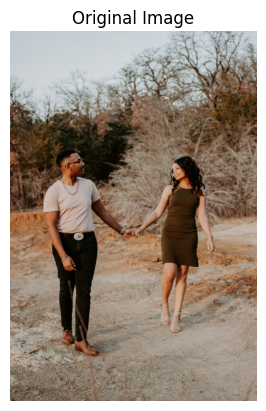

Compute the dictionnary of person...
Done.
**** Basic tests...
Question 'Is he a man?' on person with id 0 return yes
Question 'Is he a man?' on person with id 1 return no
Question 'Is he a man?' on person with id 0 and 1 return undef
Display the image of person with id=0...


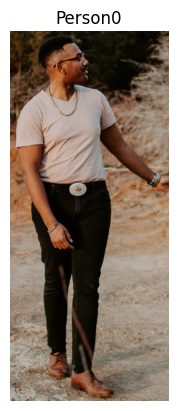

Display the board...


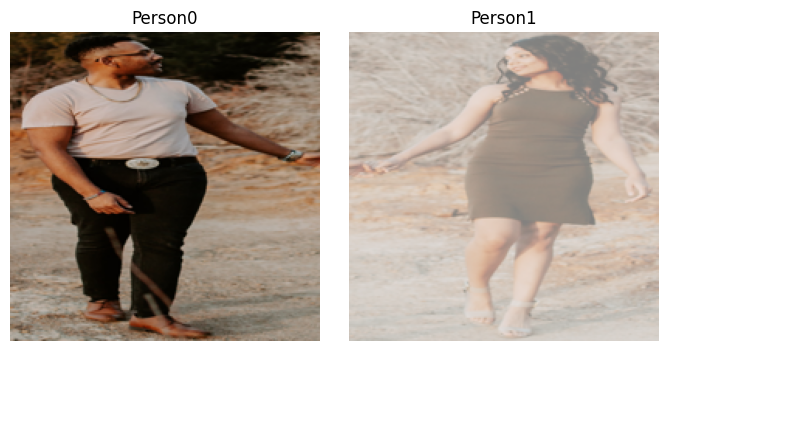

In [ ]:
# Dictionnary person generation
# At this step,
# you should have, for sample:
# question_list = ['Does he have a backpack?', 'Does he have a bag?', 'Does he have a beard?', 'Does he have a big nose?', "Does he have a bird's nose?", 'Does he have a black mustache?', 'Does he have a blonde mustache?', 'Does he have a bow-shaped mouth?', 'Does he have a brown beard?', 'Does he have a brown mustache?', 'Does he have a butterfly knot?', 'Does he have a clear complexion?', 'Does he have a flat nose?', 'Does he have a hale complexion?', 'Does he have a hat?', 'Does he have a heart-shaped face?', 'Does he have a heart-shaped mouth?', 'Does he have a little nose?', 'Does he have a long beard?', 'Does he have a medium size?', 'Does he have a mustache?', 'Does he have a phone?', 'Does he have a round chin?', 'Does he have a round mouth?', 'Does he have a sharp chin?', 'Does he have a sharp nose?', 'Does he have a short beard?', 'Does he have a short chin?', 'Does he have a short dress?', 'Does he have a short mustache?', 'Does he have a square chin?', 'Does he have a square mouth?', 'Does he have a sweater?', 'Does he have a tie?', 'Does he have a triangle face?', 'Does he have a white beard?', 'Does he have an apple-shaped mouth?', 'Does he have an elongated oval face?', 'Does he have an open mouth?', 'Does he have an oval face?', 'Does he have any big cheeks?', 'Does he have any fine eyebrows?', 'Does he have any little cheeks?', 'Does he have any red hair?', 'Does he have black eyes?', 'Does he have black skin?', 'Does he have blond hair?', 'Does he have blue eyes?', 'Does he have brown eyes?', 'Does he have brown hair?', 'Does he have buttons on his chin?', 'Does he have curly hair?', 'Does he have earrings?', 'Does he have glasses?', 'Does he have his nose troubled?', 'Does he have matt skin?', 'Does he have short pants?', 'Does he have thick eyebrows?', 'Does he have white hair?', 'Does he have white skin?', 'Is he a man?', 'Is he fat?', 'Is he tall?', 'Is he thin?', 'Is she a woman?']
# question_list_for_player_1 = ['Does he have a backpack?', 'Does he have a black beard?', 'Does he have a blonde mustache?', 'Does he have a butterfly knot?', 'Does he have a clear complexion?', 'Does he have a diamond face?', 'Does he have a hale complexion?', 'Does he have a hat?', 'Does he have a long dress?', 'Does he have a mustache?', 'Does he have a nubian nose?', 'Does he have a phone?', 'Does he have a round chin?', 'Does he have a sharp chin?', 'Does he have a sharp nose?', 'Does he have a small size?', 'Does he have a square face?', 'Does he have a very large size?', 'Does he have a white beard?', 'Does he have a white mustache?', 'Does he have an ellipse-shaped mouth?', 'Does he have an oval face?', 'Does he have any big cheeks?', 'Does he have any black hair?', 'Does he have blue eyes?', 'Does he have brown eyes?', 'Does he have curly hair?', 'Does he have earrings?', 'Does he have hair?', 'Does he have thick eyebrows?', 'Does he have white skin?', 'Does he have wide eyebrows?', 'Is he a man?', 'Is he fat?', 'Is he tall?', 'Is he thin?', 'Is she a woman?']
# question_list_for_player_2 = ['Does he have a backpack?', 'Does he have a beard?', 'Does he have a brown mustache?', 'Does he have a concave nose?', 'Does he have a dark complexion?', 'Does he have a grey beard?', 'Does he have a hat?', 'Does he have a heart-shaped face?', 'Does he have a medium size?', 'Does he have a mustache?', 'Does he have a red mustache?', 'Does he have a round chin?', 'Does he have a round mouth?', 'Does he have a sharp chin?', 'Does he have a sharp nose?', 'Does he have a short beard?', 'Does he have a short chin?', 'Does he have a short?', 'Does he have a small size?', 'Does he have a square mouth?', 'Does he have a tie?', 'Does he have an ellipse-shaped mouth?', 'Does he have any big cheeks?', 'Does he have any black hair?', 'Does he have any buttons on his mouth?', 'Does he have any little cheeks?', 'Does he have any piercings?', 'Does he have any scars?', 'Does he have blond hair?', 'Does he have blue eyes?', 'Does he have brown eyes?', 'Does he have curly hair?', 'Does he have green eyes?', 'Does he have his nose troubled?', 'Does he have matt skin?', 'Does he have white skin?', 'Does he have wide eyebrows?', 'Is he a man?', 'Is he fat?']

from PIL import Image
import cv2
import easyocr
import huggingface_hub
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from diffusers.utils import load_image
from transformers import pipeline
# If you want read the image from a directory
#import matplotlib.image as mpimg

# We recommand the usage of GPU for use the models here -> Activate the GPU on Colab.
#import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#assert device == torch.device('cuda'), "Not using CUDA. Set: Runtime > Change runtime type > Hardware Accelerator: GPU"

# We have done a mixed code between huggingface pipeline and direct pretrained model call
# You can see :
# https://huggingface.co/tasks

# constant in pixels to delimit a zone arround the face (adjust if need)
delta_face_arround_ctx_x = 20
delta_face_arround_ctx_y = 70

# Load the insightface model to detect person in a image
def load_model_detection():
    path = huggingface_hub.hf_hub_download("public-data/insightface", "models/scrfd_person_2.5g.onnx")
    options = ort.SessionOptions()
    options.intra_op_num_threads = 8
    options.inter_op_num_threads = 8
    session = ort.InferenceSession(
        path, sess_options=options, providers=["CPUExecutionProvider", "CUDAExecutionProvider"]
    )
    model = insightface.model_zoo.retinaface.RetinaFace(model_file=path, session=session)
    return model

# Method to detect a person in image, return bounding box
def detect_person(
    img: np.ndarray, detector: insightface.model_zoo.retinaface.RetinaFace
) -> tuple[np.ndarray]:
    bboxes, kpss = detector.detect(img)
    bboxes = np.round(bboxes[:, :4]).astype(int)
    return bboxes

# Extract the images of person from the source image
def extract_sub_images(image: np.ndarray, bboxes: np.ndarray) -> list[np.ndarray]:
    res = []
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        x1, y1, x2, y2 = bbox
        res.append(image[y1:y2, x1:x2])
    return res

# Init part (models and pipelines)
detector = load_model_detection()
detector.prepare(-1, nms_thresh=0.5, input_size=(640, 640))
face_detector = FaceAnalysis()
# ctx_id = 0 (GPUid), det_size of image
face_detector.prepare(ctx_id=0, det_size=(640,640))
reader = easyocr.Reader(['en','en']) # this needs to run only once to load the model into memory
vqa_pipeline = pipeline("visual-question-answering", device="cuda")

# Extract text of image (ocr)
def text_extract(image: np.ndarray) -> str:
    result = reader.readtext(image, detail = 0)
    # Remove the element with double because the name shall be unique...
    result = [r for r in result if result.count(r) == 1]
    res = ' '.join(result)
    return res

# Extract sub-image of person from the source image
def detect_extract(image: np.ndarray) -> np.ndarray:
    # Try with a complete person
    bboxes = detect_person(image, detector)
    # If not found, try with the face of person
    if len(bboxes) == 0:
        bboxes = []
        faces = face_detector.get(image)
        if len(faces) > 0:
          for i in range(len(faces)):
            x1, y1, x2, y2 = np.round(faces[i]['bbox']).astype(int)
            # Append delta arround the face to append the context and name
            if x1 - delta_face_arround_ctx_x < 0:
                x1 = 0
            else:
                x1 = x1 - delta_face_arround_ctx_x
            if y1 - delta_face_arround_ctx_y < 0:
                y1 = 0
            else:
                y1 = y1 - delta_face_arround_ctx_y
            if x2 + delta_face_arround_ctx_x > image.shape[1]:
                x2 = image.shape[0]
            else:
                x2 = x2 + delta_face_arround_ctx_x
            if y2 + delta_face_arround_ctx_y > image.shape[0]:
                y2 = image.shape[1]
            else:
                y2 = y2 + delta_face_arround_ctx_y
            x1_m = min(x1, x2)
            y1_m = min(y1, y2)
            x2_m = max(x1, x2)
            y2_m = max(y1, y2)
            bboxes.append([x1_m, y1_m, x2_m, y2_m])
    res = extract_sub_images(image, bboxes)
    return res

# Query on a image (caption). Return yes or no.
def query(image: np.ndarray, question: str) -> str:
    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image) # Convert the NumPy array to a PIL Image object
    res = vqa_pipeline({"image": image, "question": question}, top_k=1)
    #print("Proba for '%s' -> '%s' : %.02f" % (question, res[0]['answer'], res[0]['score']))
    return res[0]['answer']

# The "dictionnary" of person
dict_person = []

# To reset the dict person
def reset_dict_person():
  dict_person.clear()

# To update the dict person with all infos on the person
def update_dict_person(person_id: int, person_img: np.ndarray, question_list, ocr=False):
  person_name = ''
  if (ocr == True):
    # Search if the name of person exist in the image (optional)
    person_name = text_extract(person_img)
    # To have a short name we keep here only the first part of long name
    person_name = person_name.split()[0]
  if len(person_name) < 2:
    # Ignore the result and use a generic name
    person_name = "Person" + str(person_id)
  questions = {}
  for q in question_list:
      questions[q] = query(person_img, q)
  # Check if person_id already exists in the list of dictionaries
  person_exists = False
  for person in dict_person:
      if person.get('id') == person_id:  # Use get() to avoid KeyError if 'id' is missing
          person_exists = True
          person['name'] = person_name
          person['img'] = person_img
          person['questions'] = questions
          break
  # If person_id doesn't exist, add a new dictionary to the list
  if not person_exists:
      dict_person.append({ 'id': person_id, 'name': person_name, 'img': person_img, 'questions': questions })

# To get the name of the person
def get_name_person(person_id: int):
    return dict_person[person_id]['name']

# To get the image of the person
def get_image_person(person_id: int):
    return dict_person[person_id]['img']

# Better to have question list directly...
# To get all the questions available on a person
def get_available_questions(person_id: int):
    return list(dict_person[person_id]['questions'].keys())

# To get a answer yes or no on a question on a person
def get_answer_on_person(question: str, person_id: int):
    if question not in dict_person[person_id]['questions']:
        return "undef"
    return dict_person[person_id]['questions'][question]

# To get a answer on a question for a list of person
# Return can be "yes", "no" or "undef"
def get_answer_on_list_person(question: str, sub_list_person_id = range(len(dict_person))):
    # Check "yes" case for all the person on the sub list of person
    res = "yes"
    for person in dict_person:
      for i in sub_list_person_id:
        if person['id'] == i:
          if person['questions'][question] == "no":
            res = "no"
            break
    if res == "yes":
      return "yes"
    # Check "no" case for all the person on the sub list of person
    res = "no"
    for person in dict_person:
      for i in sub_list_person_id:
        if person['id'] == i:
          if person['questions'][question] == "yes":
            res = "yes"
            break
    if res == "no":
      return "no"
    return "undef"

# To get the nb of person
def get_nb_person():
  return len(dict_person)

# To display the game board (for one player)
def display_board(todelete_person_id = []):
  img_list = []
  for i in range(len(dict_person)):
    # Convert the NumPy array to a PIL Image object before resizing
    img = Image.fromarray(get_image_person(i)) # Convert the image to a PIL Image object
    img_list.append(img.resize((200, 200)))
  fig = plt.figure(figsize=(10., 10.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 6),  # creates 4x6 grid of Axes as the base game but you can change here.
                 axes_pad=0.3,  # pad between Axes in inch.
                 )
  for ax in grid:
    ax.axis('off')
  i=0
  for ax, im in zip(grid, img_list):
    ax.set_title(get_name_person(i))
    if i in todelete_person_id:
      # Change the color of image if deleted
      im.putalpha(128)
    ax.imshow(im)
    i+=1
  plt.axis('off')
  plt.show()

# To add a dict person from a image source
def add_dict_person(image_src: np.ndarray, ocr=False):
  nb_person = get_nb_person()
  for img in detect_extract(np.asarray(image_src)):
    update_dict_person(nb_person, img, question_list, ocr)
    nb_person +=1
  #print(dict_person)

# Unitary tests
if __name__ == "__main__":
    #
    # Create a dictionnary with all the infos on the person from a image
    # The info of dictionnary will be accessible with getters
    # Unitary tests
    #img_src = mpimg.imread('image.jpg') #Replace "image.jpg" with the path of your image
    # Simple image with two person
    image_src = load_image("https://hysts-insightface-person-detection.hf.space/file=/tmp/gradio/d6763046b20692a8c4ac16d7e38a9cd3468ef236/pexels-jasmine-carter-812258.jpg")
    plt.title('Original Image')
    plt.imshow(image_src)
    plt.axis('off')
    plt.show()
    # Begin to reset the dict person, then add with a image
    print("Compute the dictionnary of person...")
    reset_dict_person()
    add_dict_person(image_src)
    print("Done.")
    print("**** Basic tests...")
    question = 'Is he a man?'
    # or choice a random question of player 1
    # question = random.choice(question_list_for_player_1)
    # Obtain the answer on a person with id=0
    answer = get_answer_on_person(question, 0)
    print("Question '%s' on person with id %d return %s" % (question, 0, answer))
    # Obtain the answer on a person with id=1
    answer = get_answer_on_person(question, 1)
    print("Question '%s' on person with id %d return %s" % (question, 1, answer))
    # Obtain the answer on the sub list of person with id=0 and id=1
    answer = get_answer_on_list_person(question, [0,1])
    print("Question '%s' on person with id 0 and 1 return %s" % (question, answer))
    # Display the image of person with id=0
    print("Display the image of person with id=0...")
    plt.title(get_name_person(0))
    plt.imshow(get_image_person(0))
    plt.axis('off')
    plt.show()
    # Display the board with id=1 "deleted"
    print("Display the board...")
    display_board([1])


Maintenant, essayons avec une aute famille de personnages.

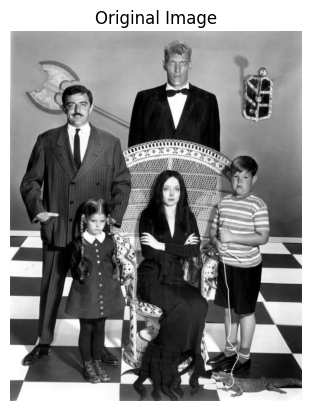

Compute the dictionnary of person...
Done.


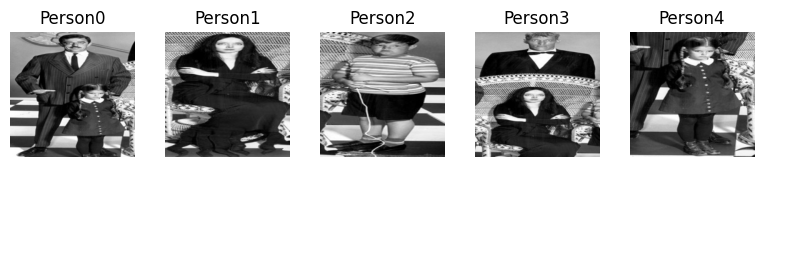

In [ ]:
image_src = load_image("https://unebrevehistoiredart.com/wp-content/uploads/2022/12/0df95d72-2545-4e75-9284-513c92123b1a.jpeg")
plt.title('Original Image')
plt.imshow(image_src)
plt.axis('off')
plt.show()
print("Compute the dictionnary of person...")
reset_dict_person()
add_dict_person(image_src)
print("Done.")
display_board()

Notez que ce n'est pas parfait lorsque les personnes sont trop proches l'une de l'autre 😥. Le découpage étant prévu pour englober autant que possible la totalité de la personne.

Nous considérons cela comme une limitation pour le moment et prendrons des images où les personnes ne sont pas trop proches les unes des autres si possible.

Et une autre essai où nous testons l'OCR.

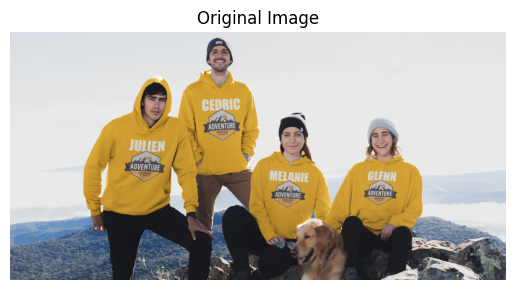

Compute the dictionnary of person...
Done.


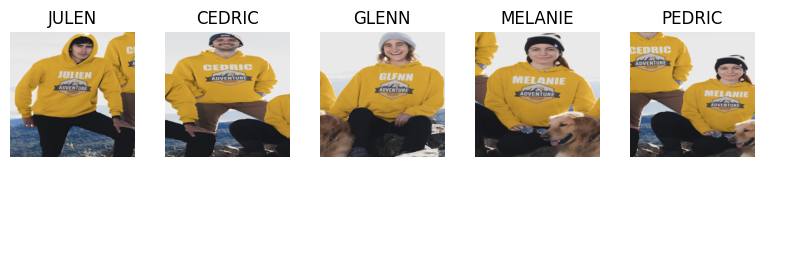

In [ ]:
image_src = load_image("https://mistertee.fr/sites/default/files/styles/blog_image/public/sweat-personnlises-avec-noms-differents-pour-club-jeunes.png")
plt.title('Original Image')
plt.imshow(image_src)
plt.axis('off')
plt.show()
print("Compute the dictionnary of person...")
reset_dict_person()
add_dict_person(image_src, ocr=True)
print("Done.")
display_board()

Notez que le programme a bien reconnu les noms des personnages sur leur tee-shirt mais a trouvé une cinquième personne inconnue / hésitation entre la position des personnes dans l'image lié au modèle.

Et avec le jeu original :

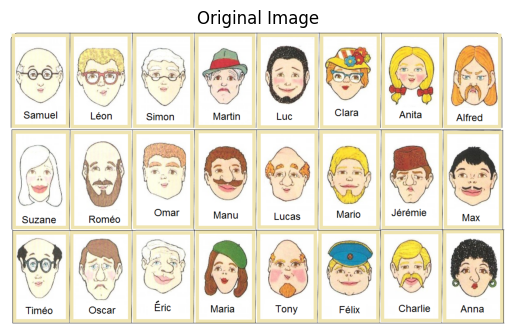

Compute the dictionnary of person...


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Done.


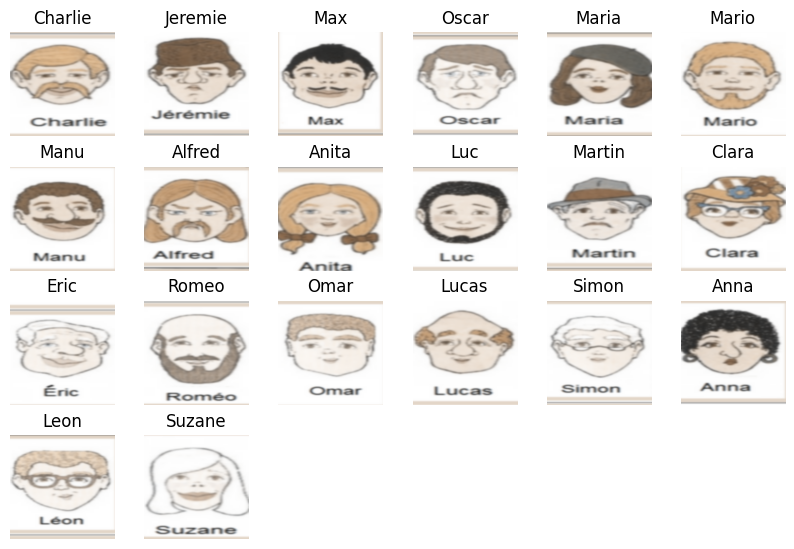

In [ ]:
# The image of 'whoami standard game'...
image_src = load_image("http://lecoindespetits.l.e.pic.centerblog.net/o/160fdab2.png")
plt.title('Original Image')
plt.imshow(image_src)
plt.axis('off')
plt.show()

# Image with bad quality
# Try to use a small gaussian filter to have a better result
from PIL import Image
from scipy import ndimage
image_src = Image.fromarray(ndimage.gaussian_filter(np.array(image_src), sigma=1.25))

print("Compute the dictionnary of person...")
reset_dict_person()
add_dict_person(image_src, ocr=True)
print("Done.")
display_board()

L'image d'origine étant de mauvaise qualité, cela n'est pas encore parfait mais nous avons une vingtaine de personnages pour nos tests. Nous nous en contenterons pour la suite.

En fait, nous aurons besoin pour la suite de deux dictionnaires :
* un dictionnaire de base correspondant à une seule image source et regroupant les personnages de cette image.
* un dictionnaire "plus évolué" où nous allons concaténer les personnages issus de plusieurs images.


Pour le dictionnaire de base, la dernière exécution précédente a compilé un ensemble proche du jeu habituel.

Nous avons juste à le garder pour la suite. Sauvons-le dans un fichier.

In [ ]:
# Save the dictionnary in a file
import numpy as np
with open('basic_dict_person.npy', 'wb') as f:
    np.save(f, dict_person)

Pour le dictionnaire plus évolué, on peut s'appuyer sur une liste d'images quelconques de groupe de personnes.

Notez que contrairement aux exemples précédents qui ont permis de montrer certaines limites dans le choix des images, nous avons de bons résultats en choisissant ici des images avec une qualité d'image satisfaisante et de bonnes conditions (personnes dans l'image suffisament loin les uns des autres).  

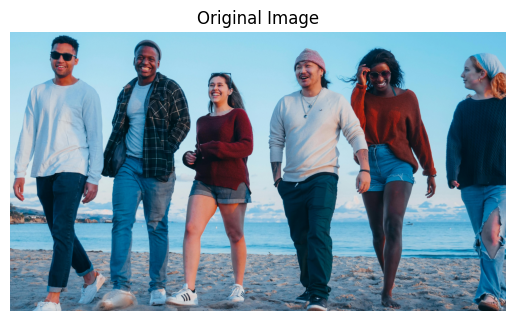

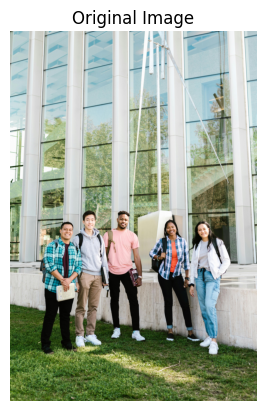

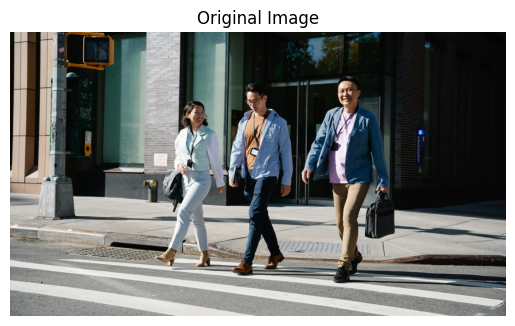

In [ ]:
list_images_src = [ "https://images.pexels.com/photos/7148445/pexels-photo-7148445.jpeg",
                    "https://images.pexels.com/photos/7683731/pexels-photo-7683731.jpeg",
                    "https://images.pexels.com/photos/7963802/pexels-photo-7963802.jpeg" ]
reset_dict_person()
for url in list_images_src:
  image_src = load_image(url)
  plt.title('Original Image')
  plt.imshow(image_src)
  plt.axis('off')
  plt.show()
  add_dict_person(image_src)

Sauvons également celui-ci dans un fichier pour la suite.

In [ ]:
# Save the dictionnary in a file
import numpy as np
with open('extended_dict_person.npy', 'wb') as f:
    np.save(f, dict_person)

Note: Si nous voulons conserver une copie de ces dictionnaires hors de notre session Colab, nous pouvons utiliser le code suivant (adaptez le chemin de stockage du dictionnaire) :

In [ ]:
%env PATH_TO_DICT=/content/drive/MyDrive/test IA/Dict/

env: PATH_TO_DICT=/content/drive/MyDrive/test IA/Dict/


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p "$PATH_TO_DICT"
!cp basic_dict_person.npy "$PATH_TO_DICT"
!cp extended_dict_person.npy "$PATH_TO_DICT"

Maintenant, nous avons, sur le principe, tout ce qu'il nous faut pour la suite du jeu : un dictionnaire contenant toutes les informations sur les personnages, la liste des questions disponibles et leurs réponses pour simuler l'environnement du jeu pour la phase d'entraînement.

Comme nous le verrons également dans la suite, pour nos travaux, nous avons besoin que les données (images et questions ici) soient suffisamment importantes et variées : Il faudrait donc réaliser l'exercice sur un plus grand nombres de données et avec également une plus grande variété (personnages et questions de différentes sources) que dans l'échantillon présenté ici pour être capable de généraliser. Nous nous bornerons dans la suite aux grandes lignes de mise en oeuvre.

# **2. Elaboration du modèle du jeu**

Nous allons élaborer le modèle de jeu.

Nous n'allons pas suivre la méthode d'apprentissage supervisé classique, nous n'allons pas entraîner le modèle à partir de données d'entrées et noter directement les résultats attendus en sortie mais plutôt réaliser un apprentissage dynamique en laissant le modèle apprendre tout seul (architecture GAN).

Pour cela, nous allons définir un environnement de jeux avec un certain degré de liberté d'exécution et deux TF-agents concurrents, un pour chaque joueur, qui vont s'affronter.

Nous utilisons une méthode d'apprentissage par renforcement hors politique pour les environnements avec des espaces d'action discrets.

Un agent DQN entraîne une fonction Q-value pour estimer la récompense cumulative actualisée à long terme attendue en suivant la politique optimale.

L'environnement du jeu sera associé à un réseau de neurone 'QNetwork'.

L'entraînement consiste à produire différentes situations de jeu aléatoires en entrées alors que chaque agent cherche à gagner la partie.

Nous avons suivi le même processus que pour l'entraînement du jeu Tic-Tac-Toe et l'avons adapté à notre besoin.

Nous vous renvoyons également vers le dernier article en pièce jointe qui propose un schéma et un pseudo-code sur DQN.

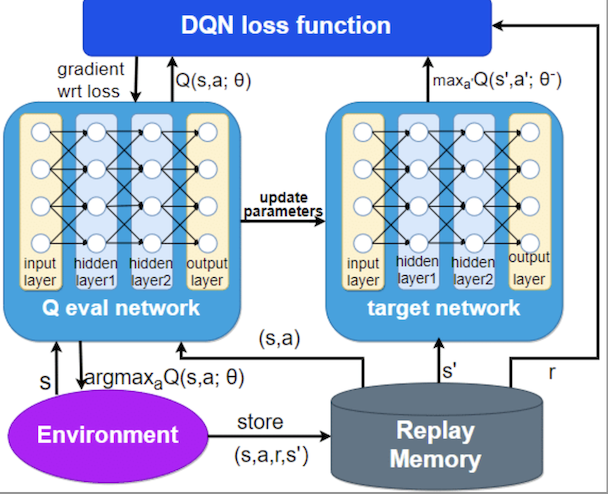

Dans la suite, s correspond à l'état du système (observation), argmaxQ est la Q-value (action_step),r (reward), le modèle de l'agent correspond au Q-Network et l'évaluation de l'agent correspond à l'exécution de l'algorithme DQN avec une politique définie (ici pseudo-aléatoire).

Note : Les modèles réalisées ici ne doivent pas être mis en production (volume des données d'entrées et entraînement insuffisant). Il s'agit ici d'un "proof-of-concept" uniquement.  

Sources :
* Multi-Agent Reinforcement Learning with TF-Agents, Dylan Cope, Jun 2020, https://github.com/DylanCope/Multi-Agent-RL-with-TF/blob/master/DMARL%20with%20TF-Agents.ipynb
* Former un réseau Deep Q avec des agents TF, Tensor Flow, https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial?hl=fr
* Code source de l'agent DQN TF, Tensor Flow, https://github.com/tensorflow/agents/blob/master/tf_agents/agents/dqn/dqn_agent.py
* Code source du réseau QNetwork TF, Tensor Flow, https://github.com/tensorflow/agents/blob/master/tf_agents/networks/q_network.py
* Learn to navigate: cooperative path planning for unmanned surface vehicles using deep reinforcement learning, Xinyuan Zhou, Peng Wu, Haifeng Zhang, Weihong Guo et Yuanchang Liu, 2017, https://www.researchgate.net/publication/337231033_Learn_to_Navigate_Cooperative_Path_Planning_for_Unmanned_Surface_Vehicles_Using_Deep_Reinforcement_Learning/download?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ


**1. Mise à jour de la configuration pour TF-agents**

Nous supposons disposer dèjà d'une configuration Colab "de base" avec Numpy, Pytorch, TensorFlow et Keras.
Cette configuration doit être mise à jour pour définir des TF-agents.

In [1]:
!pip install tensorflow==2.15.0 tensorflow-probability==0.23.0 tf-agents==0.19.0 tf-keras==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
  

Note : Des dépendances peuvent apparaître en erreur ici avec l'environnement Colab de base. Ne pas en tenir compte.

Note : D'autres dépendances ponctuelles non liées aux TF-agents seront également appelées ponctuellement dans ce chapitre.

**2. Formalisation**

Dans la suite, nous ne développerons pas la mise en oeuvre des processus pour des agents dynamiques sous TensorFlow.

Nous vous renvoyons vers la documentation et les tutoriels de TensorFlow pour cela.

Disons que l'idée de base est de définir un environnement pour le jeu (règles du jeu et mécanisme de récompense à chaque tour) dans lequel peut évoluer un agent et d'utiliser des agents concurrents dynamiques qui vont évoluer librement via des réseaux de neurones pour permettre l'apprentissage profond du jeu.

**2.1. Définition de l'environnement**

Disons que nous voulons former un agent à jouer au jeu du "Qui-est-ce ?" :

Le jeu se joue donc à l'aide d'un jeu de 24 cartes (ou plus) personnages numérotées de 1 à 24 (dans l'absolu, le nombre de cartes est paramètrable).

Chaque joueur choisi un personnage à faire découvrir à son adversaire.

À chaque tour, l'agent peut faire 3 choses : si pas déjà fait choisir un personnage à faire découvrir (état initial), poser une question ou obtenir une réponse et éliminer un sous-ensemble de cartes ou décider d'arrêter le tour en cours en annonçant un personnage.

Le but est d'annoncer le personnage de son adversaire avant celui-ci. Si on annonce un mauvais personnage final, c'est perdu (et donc gagné pour son adversaire).

D'autre part, si on a épuisé le stock de questions disponibles, il y a partie nulle.

Chaque joueur ne peut poser qu'une seule fois la même question.

Un environnement qui représente le jeu pourrait ressembler à ceci :

Actions par joueur :
* Action 0 : choisir un personnage à faire découvrir (état initial),
* Action 1 : en fontion de l'état du jeu, poser une question sur un personnage,
* Action 2 : obtenir une réponse de l'adversaire et en tenir compte,

Ce tuplet d'actions permet à chaque tour d'élmininer des cartes et d'évoluer dans le déroulement de la partie pour chaque joueur. Cela peut être vu comme une "position" dans la partie.

(une action implicite permet également de déterminer le numéro du joueur)

Observations : Etat du tableau de jeu des 2 joueurs montrant les cartes élminées par chaque joueur.

Récompense : L'objectif est de s'approcher le plus possible des 23 personnages éliminées sans dépasser. Lorsqu'il ne reste plus qu'un personnage, il faut l'annoncer sans se tromper. Comme nous sommes en multi-agent, la récompence sera fonction des parties gagnées, perdues ou nulles (personne n'a réussi à trouver, plus de questions disponibles).

Etats : Il nous faut aussi garder l'état courant de la table de jeu de chaque joueur en mémoire pour progresser dans la partie et ne sélectionner un personnage qu'une seule fois.



Nous allons nous appuyer sur les éléments produits dans la première partie (fonctions d'accès aux informations sur les personnages, questions disponibles).
Pour rappel, en particulier :

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# The "dictionnary" of person
dict_person = []

# To get the name of the person
def get_name_person(person_id: int):
    return dict_person[person_id]['name']

# To get the image of the person
def get_image_person(person_id: int):
    return dict_person[person_id]['img']

# Better to have question list directly...
# To get all the questions available on a person
def get_available_questions(person_id: int):
    return list(dict_person[person_id]['questions'].keys())

# To get a answer yes or no on a question on a person
def get_answer_on_person(question: str, person_id: int):
    if question not in dict_person[person_id]['questions']:
        return "undef"
    return dict_person[person_id]['questions'][question]

# To get a answer on a question for a list of person
# Return can be "yes", "no" or "undef"
def get_answer_on_list_person(question: str, sub_list_person_id = range(len(dict_person))):
    # Check "yes" case for all the person on the sub list of person
    res = "yes"
    for person in dict_person:
      for i in sub_list_person_id:
        if person['id'] == i:
          if person['questions'][question] == "no":
            res = "no"
            break
    if res == "yes":
      return "yes"
    # Check "no" case for all the person on the sub list of person
    res = "no"
    for person in dict_person:
      for i in sub_list_person_id:
        if person['id'] == i:
          if person['questions'][question] == "yes":
            res = "yes"
            break
    if res == "no":
      return "no"
    return "undef"

# To get the nb of person
def get_nb_person():
  return len(dict_person)

# To display the game board (for one player)
def display_board(todelete_person_id = []):
  img_list = []
  for i in range(len(dict_person)):
    # Convert the NumPy array to a PIL Image object before resizing
    img = Image.fromarray(get_image_person(i)) # Convert the image to a PIL Image object
    img_list.append(img.resize((200, 200)))
  fig = plt.figure(figsize=(10., 10.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 6),  # creates 4x6 grid of Axes as the base game but you can change here.
                 axes_pad=0.3,  # pad between Axes in inch.
                 )
  for ax in grid:
    ax.axis('off')
  i=0
  for ax, im in zip(grid, img_list):
    ax.set_title(get_name_person(i))
    if i in todelete_person_id:
      # Change the color of image if deleted
      im.putalpha(128)
    ax.imshow(im)
    i+=1
  plt.axis('off')
  plt.show()


Si vous avez besoin de récupérer vos dictionnaires précédemment copiés dans la première partie :

In [3]:
%env PATH_TO_DICT=/content/drive/MyDrive/test IA/Dict/

env: PATH_TO_DICT=/content/drive/MyDrive/test IA/Dict/


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp "$PATH_TO_DICT/basic_dict_person.npy" .
!cp "$PATH_TO_DICT/extended_dict_person.npy" .

Mounted at /content/drive


Commencons par le cas le plus simple avec le dictionnaire "de base".

In [18]:
dict_person = []

# load the dictionnary
import numpy as np
with open('basic_dict_person.npy', 'rb') as f:
    dict_person = np.load(f, allow_pickle=True)

question_list = get_available_questions(0)
# A sample of partition of questions between two player
question_list_for_player_1 = question_list[:len(question_list)//2]
question_list_for_player_2 = question_list[len(question_list)//2:]

nb_person = get_nb_person()
nb_question = len(question_list)

print("question_list_for_player_1 = ")
print(question_list_for_player_1)

print("question_list_for_player_2 = ")
print(question_list_for_player_2)

print("question_list = ")
print(question_list)

print("nb_person = ")
print(nb_person)

print("nb_question = ")
print(nb_question)

question_list_for_player_1 = 
['Does he have a beard?', 'Does he have a belt?', 'Does he have a black beard?', 'Does he have a bow-shaped mouth?', 'Does he have a brown beard?', 'Does he have a butterfly knot?', 'Does he have a clear complexion?', 'Does he have a concave nose?', 'Does he have a dark complexion?', 'Does he have a diamond face?', 'Does he have a flat nose?', 'Does he have a grey beard?', 'Does he have a grey mustache?', 'Does he have a hale complexion?', 'Does he have a heart-shaped face?', 'Does he have a heart-shaped mouth?', 'Does he have a little nose?', 'Does he have a long dress?', 'Does he have a medium size?', 'Does he have a red mustache?', 'Does he have a round chin?', 'Does he have a scarf?', 'Does he have a sharp chin?', 'Does he have a sharp nose?', 'Does he have a short mustache?', 'Does he have a small size?', 'Does he have a sweater?', 'Does he have a triangle face?', 'Does he have a twisted nose?', 'Does he have a very large size?']
question_list_for_pla

Sous TensorFlow, l'environnement de notre jeu pourrait ressembler à ceci :

In [19]:
import tensorflow as tf
import numpy as np
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.trajectories.time_step import StepType
from tf_agents.trajectories.time_step import TimeStep
from tf_agents.specs import BoundedTensorSpec
from tf_agents.specs import BoundedArraySpec

random.seed(1)

# Activate log by default
log = True

# Lie/error factor (here 5%)
lie_factor = 0.05

class WhoAmIMultiAgentEnv(py_environment.PyEnvironment):
  """A state-settable environment for WhoAmI game.

  The states of board are a 24 x 2 (one per player) array where on each item we have the state :
      0 = not tested, 1 = tested and kept, 2 = tested and deleted.
  The action is a 2-d vector to indicated at each once (selected item fixed, question (from the player for the opposite), answer (from the player for the opposite), player) for each player.
  """
  REWARD_WIN = np.asarray(1., dtype=np.float32)
  REWARD_LOSS = np.asarray(-1., dtype=np.float32)
  REWARD_NOT_FINAL = np.asarray(0., dtype=np.float32)

  REWARD_WIN.setflags(write=False)
  REWARD_LOSS.setflags(write=False)
  REWARD_NOT_FINAL.setflags(write=False)

  # Specific
  # query on a person return always yes or no
  def _query_item(self,person_id,index_question):
      # Noise because we can have a error
      p = random.random()
      if p < lie_factor:
        return random.choice([True, False])
      question = question_list[index_question]
      ret = get_answer_on_person(question, person_id)
      if ret == "yes":
        return True
      if ret == "no":
        return False

  def _provide_new_question(self, sub_list_person_id, list_question_id_already_used):
      # We can suppose that we choose a question in a list of questions available
      # Each question can be used only once.
      # So, we should found a question compatible with all the elements of list_person_id
      # If not found, try with only the first element, also the next...
      # query on a sub list of person can return yes, no or undef
      r_question_list = list(question_list)
      for i in list_question_id_already_used:
        if question_list[i] in r_question_list:
          r_question_list.remove(question_list[i])
      random.shuffle(r_question_list)
      for q in r_question_list:
        ret = get_answer_on_list_person(q, sub_list_person_id)
        if ret == "yes" or ret == "no":
          # Id of the question
          index_question = question_list.index(q)
          return index_question
      # if not found try on each element, one by one (shall already exist)
      for q in r_question_list:
        for person_id in sub_list_person_id:
          ret = get_answer_on_person(q, person_id)
          if ret == "yes" or ret == "no":
            # Id of the question
            index_question = question_list.index(q)
            return index_question
      # undef case / no question available
      return None

  def __init__(self, rng: np.random.RandomState = None, discount=1.0):
    """Initializes WhoAmIMultiEnvironment.

    Args:
      rng: If a random generator is provided, the opponent will choose a random
        empty space. If None is provided, the opponent will choose the first
        empty space.
      discount: Discount for reward.
    """
    super(WhoAmIMultiAgentEnv, self).__init__()
    self._rng = rng
    self._discount = np.asarray(discount, dtype=np.float32)
    # Now we suppose that we have the sequence of questions
    self._seq_questions = None
    self._states = None
    self._current_action = None

  def action_spec(self):
    # Get the action spec for 'selected_item'
    # A selected item is an item that opposite shall found
    selected_item_spec = BoundedTensorSpec(
        shape=(2,), dtype=tf.int32, minimum=0, maximum=nb_person-1, name='action'
    )  # Assuming 'selected_item' is a single integer between 0 and nb_person-1
    # Get the action spec for 'question'
    # A question is to the opposite which shall give an response
    question_spec = BoundedTensorSpec(
        shape=(2,), dtype=tf.int32, minimum=0, maximum=nb_question-1, name='action'
    )  # Assuming 'question' is a single integer (question number) in a predefined question between 0 and nb_question-1
    # Get the action spec for 'response'
    # A answer is to the result of question on a question_item
    # A answer will be a 0 ('no') or 1 ('yes')
    answer_spec = BoundedTensorSpec(
        shape=(2,), dtype=tf.int32, minimum=0, maximum=1, name='action'
    )  # Assuming 'answer' is a single integer 0 or 1 / True or False
    # Get the action spec for 'player'
    player_spec = BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=1, maximum=2, name='action'
    )  # Assuming 'player' is a single integer 1 and 2 (player number)

    return {
        'selected_item': selected_item_spec,
        'question': question_spec,
        'answer': answer_spec,
        'player': player_spec
    }

  def observation_spec(self):
    # In observation we have the board for the two players
    # Each person in the board is : 'no tested' = 0, 'tested and kept' = 1, 'tested and deleted' = 2 states
    return BoundedArraySpec((nb_person, 2), np.int32, minimum=0, maximum=2)

  def _reset(self):
    self._states = np.zeros((nb_person, 2), np.int32)
    self._seq_questions = [ [] , [] ]
    #self._current_action = None
    return TimeStep(StepType.FIRST, np.asarray(0.0, dtype=np.float32),
                    self._discount, self._states)

  def _legal_actions(self, states: np.ndarray):
    # We can't play a person new state < current state
    return list(zip(*np.where(states >= self._states)))

  # Return the current list of deleted items for each player
  def get_deleted_items(self):
    return list(zip(*np.where(self._states == 2)))

  # Return the sequence of questions from start for each player
  def get_seq_questions(self):
    return self._seq_questions

  def get_state(self) -> TimeStep:
    # Returning an unmodifiable copy of the state.
    return copy.deepcopy(self._current_time_step)

  def set_state(self, time_step: TimeStep):
    self._current_time_step = time_step
    self._states = time_step.observation

  def get_current_action(self):
    return self._current_action

  def _step(self, action: np.ndarray):
    if self._current_time_step.is_last():
        return self._reset()

    # Convert the action to a dictionary if it's not already
    if not isinstance(action, dict):
        # Check if action is a scalar and convert it to a list
        if np.isscalar(action):
            action = [action]
        # Assuming action is a numpy array with shape (1, 4)
        # where the first element is selected item, etc.

        # If selected items not defined, provide a random choice
        selected_item = np.array([ 0, 0 ])
        selected_item[0] = random.choice(range(nb_person))
        selected_item[1] = selected_item[0]
        while(selected_item[0] == selected_item[1]):
          selected_item[1] = random.choice(range(nb_person))

        action = {
             # action[0] = random.choice(nb_person) do (action[1] = random.choice(nb_person)) while(action[0] == action[1])
             #'selected_item': np.array([ action[0], action[1] ]),  # Get the selected item from the array (one per player)
            'selected_item': selected_item, # Get the selected item from the array (one per player)
            'question': np.array([ question_list.index(random.choice(question_list_for_player_1)), question_list.index(random.choice(question_list_for_player_2)) ]),  # Get the question nb from the array (one per player). By default, a random question choosen in each list of question per player
            'answer': np.array([ 0, 0 ]),  # Get the answer number from the array (one per player), default is 0, 0 (will be updated by environment)
            'player': 1 # Get the current player from the array (player 1 by default) - values are 1 or 2
        }

    # Record the current question in the sequence of questions
    self._seq_questions[action['player']-1].append(action['question'][action['player']-1])
    self._seq_questions[2-action['player']].append(action['question'][2-action['player']])

    # Give the answer for other player
    # query on the selected item of player with the question of other player
    action['answer'][action['player']-1] = self._query_item(action['selected_item'][action['player']-1],action['question'][2-action['player']])

    # opponent
    action['answer'][2-action['player']] = self._query_item(action['selected_item'][2-action['player']],action['question'][action['player']-1])

    # Update the states of the board for the player
    # No considered the selected item of player
    self._states[action['selected_item'][action['player']-1]][action['player']-1] = 2
    # opponent
    self._states[action['selected_item'][2-action['player']]][2-action['player']] = 2

    for i in range(len(self._states)):
        # Check only not already deleted items
        if self._states[i][action['player']-1] != 2:
            # We have already give a question and have an answer
            if action['question'][action['player']-1] != None and action['answer'][2-action['player']] != None:
                # Elements of item i are founded with the same question and with an answer known
                if self._query_item(i,action['question'][action['player']-1]) == 1 and action['answer'][2-action['player']] == 0:
                    self._states[i][action['player']-1] = 2
                else:
                  if self._query_item(i,action['question'][action['player']-1]) == 0 and action['answer'][2-action['player']] == 1:
                      self._states[i][action['player']-1] = 2
                  else:
                      self._states[i][action['player']-1] = 1

    # Update the question for other player
    # The question shall be pertinent with the rest of item available
    index_item_for_next_question = list(zip(*np.where(self._states[:, action['player']-1] != 2)))
    for i in range(len(index_item_for_next_question)):
      index_item_for_next_question[i] = index_item_for_next_question[i][0]

    # Compute a next question will be used if necessary
    # This is a default question which can be overrided
    ret1 = self._provide_new_question(index_item_for_next_question, self._seq_questions[action['player']-1])

    # No question available
    if ret1 == None:
      if log:
        print("Draw : No question available")
      return TimeStep(StepType.LAST,
                      WhoAmIMultiAgentEnv.REWARD_NOT_FINAL,
                      self._discount,
                      self._states)

    action['question'][action['player']-1] = ret1

    # For other player
    index_item_for_next_question_2 = list(zip(*np.where(self._states[2-action['player'], :] != 2)))
    for i in range(len(index_item_for_next_question_2)):
      index_item_for_next_question_2[i] = index_item_for_next_question_2[i][0]

    ret2 = self._provide_new_question(index_item_for_next_question_2, self._seq_questions[2-action['player']])

    # No question available
    if ret2 == None:
      if log:
        print("Draw : No question available")
      return TimeStep(StepType.LAST,
                      WhoAmIMultiAgentEnv.REWARD_NOT_FINAL,
                      self._discount,
                      self._states)

    action['question'][2-action['player']] = ret2

    # Check the last item available (for current player only)
    if len(index_item_for_next_question) == 1:
        if action['selected_item'][2-action['player']] == index_item_for_next_question[0]:
            self._states[index_item_for_next_question[0]][action['player']-1] = 2
            if log:
              print("Win ! Found the opposite selected item")
            return TimeStep(StepType.LAST,
                            WhoAmIMultiAgentEnv.REWARD_WIN,
                            self._discount,
                            self._states)
        else:
            if log:
              print("Loss : Failed on the last question")
            return TimeStep(StepType.LAST,
                            WhoAmIMultiAgentEnv.REWARD_LOSS,
                            self._discount,
                            self._states)

    # Check board state
    is_final, reward = self._check_states(self._states)

    if np.all(self._states == 0):
        step_type = StepType.FIRST
    elif is_final:
        step_type = StepType.LAST
    else:
        step_type = StepType.MID

    # record current action
    self._current_action = action

    return TimeStep(step_type, reward, self._discount, self._states)

  def _check_states(self, states: np.ndarray):
    """Check if the given states are final and calculate reward.

    Args:
      states: states of the board.

    Returns:
      A tuple of (is_final, reward) where is_final means whether the states
      are final are not, and reward is the reward for stepping into the states
      The meaning of reward: 0 = not decided or draw, 1 = win, -1 = loss
    """

    # All item deleted for player 1... but this player haven't found the opposite item selected
    if sum(states[i][0] == 2 for i in range(len(states))) == len(states):
        if log:
          print("Loss : All item deleted for player... but this player haven't found the opposite item selected")
        return True, WhoAmIMultiAgentEnv.REWARD_LOSS  # loss

    # All item deleted for player 2... but this player haven't found the opposite item selected
    if sum(states[i][1] == 2 for i in range(len(states))) == len(states):
        if log:
              print("Win ! Opposite failed to find your selected item")
        return True, WhoAmIMultiAgentEnv.REWARD_WIN  # win

    # Not final (transition)
    #if 0 in states or 1 in states:
    ## Compute transition reward with the states of board
    #reward_p1 = sum(states[i][0] for i in range(len(states))) / ((0.0 + 1.0 + 2.0) * len(states))
    #reward_p2 = sum(states[i][1] for i in range(len(states))) / ((0.0 + 1.0 + 2.0) * len(states))
    #if reward_p1 > reward_p2:
    #  reward =  np.asarray((reward_p1 - reward_p2), dtype=np.float32)
    #else:
    #  reward =  np.asarray((reward_p1 - reward_p2), dtype=np.float32)
    #return False, reward

    if 0 in states:
      # Not final (transition)
      return False, WhoAmIMultiAgentEnv.REWARD_NOT_FINAL

    if 1 in states:
      # Not final (transition)
      return False, WhoAmIMultiAgentEnv.REWARD_NOT_FINAL

    # Not winner...
    if log:
      print("Draw : No final item deleted")
    return True, WhoAmIMultiAgentEnv.REWARD_NOT_FINAL  # draw

Dans notre environnement, on retrouve les actions décrites précédemment. L'état du jeu correspond au plateau de jeu des 2 joueurs. Les actions concernent donc les 2 joueurs. Chacun devant remplir sa partie.

Concernant le calcul du gain, nous avons retenu les situations de jeu évidentes conduisant à une partie gagnée (+1), perdue (-1) ou nulle (0) avec pour les transitions (0).

Nous avons également testé une autre mesure du gain intermédiaire dans la période transitoire (entre -1 et +1) en commentaire dans le code car non retenue ici mais qui pourrait s'avérer également intéressante. Ce gain tient compte de l'état du tableau de bord du joueur mais également de celui de son adversaire. Celui qui est dans la meilleur position de gagner étant celui qui est le plus proche de sélectionner le personnage final tandis que son adversaire est éloigné de pouvoir le faire.    

Notez que, dans notre environnement, la cohérence des questions et des réponses est partiellement contrôlée ce qui réduit les dégrés de liberté mais semble plus cohérent.

En fait, le joueur n'a pas le droit de donner dans l'absolu une réponse incohérente avec la question posée. La réponse est donc contrainte et calculée par la question dans l'environnement de jeu.  

Concernant les questions, si l'on ne donne pas de question initiale, on tire aléatoirement la question.

On donne ensuite automatiquement une question cohérente avec l'état du jeu si celle-ci n'est pas explicitement fournie à chaque action (cf. *_provide_new_question()*). L'utilisation de l'environnement offre donc deux politiques d'utilisation : Utiliser une question quelconque externe ou s'appuyer sur l'environnement pour trouver une question. Dans l'absolu, une question ne devrait être posée qu'une seule fois et la partie s'arrêtera toujours si on n'a plus de questions donc au bout de *nb_question* tours de jeu.

Le nombre total de personnages du jeu (*nb_person*) et le nombre de questions (*nb_question*) sont donc liés. Il faut que *nb_question > nb_person* et même que *nb_question >> nb_person*.  

La réponse est toujours fournie à partir de l'état du dictionnaire (on connaît déjà les réponses à toutes les questions possibles sur un personnage calculées dans la première partie - *_query_item()*).

On a introduit malgré tout un léger biais aléatoire dans la réponse drot à l'erreur ou facteur de mensonge...). L'adversaire peut donc "mentir" dans le jeu. Ici, on a introduit juste une probabilité de mensonge pour chaque réponse dans *_query_item()*. On pourrait développer un vrai modèle pour traiter ce point. Plus ce facteur est important et plus on a de chance de ne pas trouver le personnage final et perdre la partie (des deux côtés).

Vous noterez que sans entraînement on ne gagne pas souvent la partie en trouvant le bon personnage non plus.

De plus, à noter pour la suite, que comme le choix du personnage initial est un état initial et la réponse est calculée dans l'environnement, seul la séquence des questions fait évoluer l'état du jeu.

Nous avons laissé un faible niveau de degré de liberté dans l'environnement car notre objectif est porté par les questions/trouver les bonnes questions plutôt que par le jeu lui-même.

On commence par vérifier le format de l'environnement. Répétez plusieurs fois la commande pour vérifier que les différentes fin de partie possibles se réalisent. Notez que l'on ne gagne pas facilement en trouvant le bon personnage.

In [ ]:
environment = WhoAmIMultiAgentEnv()
utils.validate_py_environment(environment, episodes=20)

Loss : Failed on the last question
Loss : Failed on the last question
Win ! Found the opposite selected item
Loss : Failed on the last question
Loss : Failed on the last question
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Opposite failed to find your selected item
Loss : Failed on the last question
Loss : All item deleted for player... but this player haven't found the opposite item selected
Win ! Found the opposite selected item
Loss : All item deleted for player... but this player haven't found the opposite item selected
Loss : Failed on the last question
Loss : Failed on the last question
Win ! Opposite failed to find your selected item
Loss : Failed on the last question
Loss : All item deleted for player... but this player haven't found the opposite item selected
Loss : All item deleted for player... but this player haven't found the opposite item selected
Win ! Opposite failed to find your selected item
Win ! Opposite failed to find your select

Maintenant que nous savons que le format de l'environnement est vérifié, exécutons-le sur quelques scénarios pour vérifier qu'il fonctionne comme prévu.

Une petite méthode qui nous permettra d'afficher l'état de la partie de manière synthétique pour le moment.

In [20]:
def print_whoami(state):
    # Get the number of persons for formatting
    num_persons = state.shape[0]

    # Create a dynamic format board string
    format_board_elements = ["{}" for _ in range(num_persons)]
    format_board = " | ".join(format_board_elements) + "\n"
    format_board = format_board + "- + " * (num_persons - 1) + "-\n"

    table_str_1 = format_board.format(*tuple(state[:, 0].flatten()))
    table_str_1 = table_str_1.replace('0', ' ')
    table_str_1 = table_str_1.replace('1', '?')
    table_str_1 = table_str_1.replace('2', 'X')
    print("Player 1 :")
    print(table_str_1)
    table_str_2 = format_board.format(*tuple(state[:, 1].flatten()))
    table_str_2 = table_str_2.replace('0', ' ')
    table_str_2 = table_str_2.replace('1', '?')
    table_str_2 = table_str_2.replace('2', 'X')
    print("Player 2 :")
    print(table_str_2)

def print_seq_questions(seq: np.ndarray):
    print("Sequence of questions:")
    print("Player 1 :")
    for n in seq[0]:
      print("- " + question_list[n])
    print("Player 2 :")
    for n in seq[1]:
      print("- " + question_list[n])

def yesno(value):
  """Converts 0 or 1 to 'no' or 'yes' respectively."""
  return "yes" if value else "no"

Essayons de dérouler l'environnement pour voir ce qui se passe.

En modifiant la valeur de *test_policy* vous pouvez tester les deux modes d'injection : mise à jour des questions aléatoirement ou prise en compte des questions pseudo aléatoires 'par défaut' produites par l'environnement en tenant compte de l'état du jeu.

In [21]:
import random

whoami_env = WhoAmIMultiAgentEnv()

ts = whoami_env.reset()
print('Reward:', ts.reward, 'Board:')
print_whoami(ts.observation)

random.seed(1)

# Players begin to choose a random person
selected_item = np.array([ 0, 0 ])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while(selected_item[0] == selected_item[1]):
  selected_item[1] = random.choice(range(nb_person))

# Player 1 begin
player = 1

log=True

# test policy
# if test policy is 1, the questions will be computed by the environment
# also, the question will be random injected
# You can update this value to test other policy
test_policy =0
#test_policy = 1

# Copy of question list
r_question_list_for_player_1 = list(question_list_for_player_1)
r_question_list_for_player_2 = list(question_list_for_player_2)

# The question will be mean computed by environment
if test_policy == 1:
    # The question will be mean computed by environment
    # First question
    q_gen_1 = question_list.index(random.choice(question_list_for_player_1))
    q_gen_2 = question_list.index(random.choice(question_list_for_player_2))
    action = {
      'selected_item': selected_item,
      'question': np.array([ q_gen_1, q_gen_2 ]),
      'answer': np.array([ 0, 0 ]), # Always redefined by environment
      'player': player
    }

while not ts.is_last():
    if test_policy != 1:
        # Here the questions are random injected
        q_gen_1 = question_list.index(random.choice(r_question_list_for_player_1))
        q_gen_2 = question_list.index(random.choice(r_question_list_for_player_2))
        # To use the question only once
        r_question_list_for_player_1.remove(question_list[q_gen_1])
        r_question_list_for_player_2.remove(question_list[q_gen_2])
        action = {
          'selected_item': selected_item,
          'question': np.array([ q_gen_1, q_gen_2 ]),
          'answer': np.array([ 0, 0 ]), # Always redefined by environment
          'player': player
        }
    else:
        # Update only the player
        action['player'] = player

    other_player = 1 + player % 2
    print('Player:', player, '\n',
          'Question of player:', question_list[action['question'][player-1]], '\n',
          'Answer of other player:', yesno(action['answer'][other_player-1]), '\n',
          'Question of other player:', question_list[action['question'][other_player-1]], '\n',
          'Answer of player:', yesno(action['answer'][player-1]), '\n',
          'Reward:', ts.reward, 'Board:')
    ts = whoami_env.step(action)
    print_whoami(ts.observation)
    print_seq_questions(whoami_env.get_seq_questions())
    player = other_player

Reward: 0.0 Board:
Player 1 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player: 1 
 Question of player: Does he have a triangle face? 
 Answer of other player: no 
 Question of other player: Does he have thick eyebrows? 
 Answer of player: no 
 Reward: 0.0 Board:
Player 1 :
X | X | ? | X | X | ? | X | ? | X | X | ? | X | X | X | X | X | X | X | ? | X
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | X |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Sequence of questions:
Player 1 :
- Does he have a triangle face?
Player 2 :
- Does he have thick eyebrows?
Player: 2

Dans la suite, nous prendrons la stratégie de tirage pseudo-aléatoire des questions de l'environnement.

Tout semble conforme à l'attendu.

**2.2. Définition de l'interface multi-agents**

Maintenant, nous allons entraîner les agents à s'affronter et apprendre mutuellement l'un de l'autre en utilisant une interface multi-agents "standard" *IMAgent* (cf. code source également dans les sources si besoin) :

In [22]:
import tensorflow as tf
from tf_agents.agents import DqnAgent
from tf_agents.environments.tf_py_environment import TFPyEnvironment
#from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks.q_network import QNetwork
from tf_agents.specs import TensorSpec
from typing import Tuple, List, Callable
from tf_agents.trajectories import trajectory
from tf_agents.trajectories.time_step import TimeStep
from tf_agents.trajectories.trajectory import Trajectory
from tf_agents.agents.tf_agent import LossInfo
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.utils import common # Import the common module

class IMAgent(DqnAgent):

    def __init__(self,
                 env: TFPyEnvironment,
                 observation_spec: TensorSpec = None,
                 action_spec: TensorSpec = None,
                 reward_fn: Callable = lambda time_step: time_step.reward,
                 action_fn: Callable = lambda action: action,
                 name: str='IMAgent',
                 q_network=None,
                 # training params
                 replay_buffer_max_length: int = 1000,
                 learning_rate: float = 1e-5,
                 training_batch_size: int = 8,
                 training_parallel_calls: int = 3,
                 training_prefetch_buffer_size: int = 3,
                 training_num_steps: int = 2,
                 **dqn_kwargs):

        self._env = env
        self._reward_fn = reward_fn
        self._name = name
        self._observation_spec = observation_spec or self._env.observation_spec()
        self._action_spec = action_spec or self._env.action_spec()
        self._action_fn = action_fn
        #self._num_actions = self._action_spec.maximum - self._action_spec.minimum + 1

        q_network = q_network or self._build_q_net()

        env_ts_spec = self._env.time_step_spec()
        time_step_spec = TimeStep(
            step_type=env_ts_spec.step_type,
            reward=env_ts_spec.reward,
            discount=env_ts_spec.discount,
            observation=q_network.input_tensor_spec
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        super().__init__(time_step_spec,
                         self._action_spec,
                         q_network,
                         optimizer,
                         name=name,
                         **dqn_kwargs)

        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size)
        self._rewards = []

        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=self.collect_data_spec,
            batch_size=self._env.batch_size,
            max_length=replay_buffer_max_length)

        self._training_batch_size = training_batch_size
        self._training_parallel_calls = training_parallel_calls
        self._training_prefetch_buffer_size = training_prefetch_buffer_size
        self._training_num_steps = training_num_steps
        self.train = common.function(self.train)

    def _build_q_net(self):
#         q_net = QRnnNetwork(input_tensor_spec=self._observation_spec,
#                             action_spec=self._action_spec,
#                             name=f'{self._name}QRNN')

        # Use 50 internal layers for QNetwork
        fc_layer_params = (50,)

        q_net = QNetwork(
            self._observation_spec,
            self._action_spec,
            fc_layer_params=fc_layer_params)

        q_net.create_variables()
        q_net.summary()

        return q_net

    def reset(self):
        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size
        )
        self._rewards = []

    def episode_return(self) -> float:
        return np.sum(self._rewards)

    def _observation_fn(self, observation: tf.Tensor) -> tf.Tensor:
        """
            Takes a tensor with specification self._env.observation_spec
            and extracts a tensor with specification self._observation_spec.

            For example, consider an agent within an NxN maze environment.
            The env could expose the entire NxN integer matrix as an observation
            but we would prefer the agent to only see a 3x3 window around their
            current location. To do this we can override this method.

            This allows us to have different agents acting in the same environment
            with different observations.
        """
        return observation

    def _augment_time_step(self, time_step: TimeStep) -> TimeStep:

        reward = self._reward_fn(time_step)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        if reward.shape != time_step.reward.shape:
            reward = tf.reshape(reward, time_step.reward.shape)

        observation = self._observation_fn(time_step.observation)

        return TimeStep(
            step_type=time_step.step_type,
            reward=reward,
            discount=time_step.discount,
            observation=observation
        )

    def _current_time_step(self) -> TimeStep:
        time_step = self._env.current_time_step()
        time_step = self._augment_time_step(time_step)
        return time_step

    def _step_environment(self, action) -> TimeStep:
        action = self._action_fn(action)
        time_step = self._env.step(action)
        time_step = self._augment_time_step(time_step)
        return time_step

    def act(self, collect=False) -> Trajectory:
        time_step = self._current_time_step()

        if collect:
            policy_step = self.collect_policy.action(
                time_step, policy_state=self._policy_state)
        else:
            policy_step = self.policy.action(
                time_step, policy_state=self._policy_state)

        self._policy_state = policy_step.state
        next_time_step = self._step_environment(policy_step.action)
        traj = trajectory.from_transition(time_step, policy_step, next_time_step)

        self._rewards.append(next_time_step.reward)

        if collect:
            self._replay_buffer.add_batch(traj)

        return traj

    def train_iteration(self) -> LossInfo:
        experience, info = self._replay_buffer.get_next(
            sample_batch_size=self._training_batch_size,
            num_steps=self._training_num_steps
        )
        return self.train(experience)

    def get_replay_buffer(self) -> TFUniformReplayBuffer:
        return self._replay_buffer

Puis nous instancions cette classe pour les deux joueurs.

Notez que la classe est caractérisée en particulier par une action avec un focus sur les questions dans le déroulement de la partie et une valeur correspondante au joueur qui joue.

Le nombre maximum de steps et la position dans la partie sont bornés par le nombre de questions disponibles.


Nous avons défini également une fonction *ttt_action_fn* qui transforme l'action_step sous forme de scalaire en action pour l'environnement si besoin. Ici la fonction prend directement les actions calculées par l'environnement sauf si une question a été choisie par un utilisateur (nous l'utiliserons dans la suite).

In [23]:
from functools import partial

random.seed(1)

# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
    selected_item[1] = random.choice(range(nb_person))

# Used to manual definition only
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None

def ttt_action_fn(player, action_step):
    """
    Converts a scalar action_step to a dictionary of actions for the environment.

    Args:
        player: The player (1 or 2).
        action_step: The scalar action.

    Returns:
        A dictionary of actions.
    """

    # Uncomment here if you want control the questions also use environment controlled
    ## Convert action to a NumPy array or a Python integer if it's a Tensor
    #action_step = action_step.numpy() if tf.is_tensor(action_step) else action_step
    ## If action_step is still an array (e.g., shape (1,)), get the scalar value
    #if isinstance(action_step, np.ndarray) and action_step.shape == (1,):
    #    action_step = action_step.item()

    # Extract the individual action components from the scalar action_step using divmod
    #question1, question2 = divmod(action_step, nb_question)

    # Position is environment controlled so we don't use 'action_step' as position.
    current_action_dict = tf_ttt_env.envs[0].get_current_action()
    question1_id = current_action_dict['question'][0]
    question2_id = current_action_dict['question'][1]

    # Only if we want define user question
    if selected_question_id_for_player_1 != None:
        question1_id = selected_question_id_for_player_1
    if selected_question_id_for_player_2 != None:
        question2_id = selected_question_id_for_player_2

    # Create the dictionary of actions
    # Note: selected_item is computed as an initial condition
    action_dict = {
       'selected_item': tf.convert_to_tensor(np.array([selected_item]), dtype=tf.int32),
       'question': tf.convert_to_tensor(np.array([[question1_id, question2_id]]), dtype=tf.int32),
       'answer': tf.convert_to_tensor(np.array([[0, 0]]), dtype=tf.int32), # Always redefined by environment
       'player': tf.convert_to_tensor(np.array([player]), dtype=tf.int32)
    }

    return action_dict


tf_ttt_env = TFPyEnvironment(whoami_env)

# The number of steps is limited by the number of questions
nb_action_max = nb_question

action_spec = BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0., maximum=nb_action_max-1, name='action')

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 1),
    name='Player1'
)

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2'
)

Model: "QNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  2050      
 etwork)                                                         
                                                                 
 dense_25 (Dense)            multiple                  3111      
                                                                 
Total params: 5161 (20.16 KB)
Trainable params: 5161 (20.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "QNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  2050      
 etwork)                                                         
                                                                 
 dense

Notez que les réseaux QNetwork sont composés de deux couches cachées TensorFlow : une couche d'encodage (transforme les différents états d'observation de l'environnement du jeu en vecteur scalaire) suivi d'une couche dense de neurones profond (de taille nb_action_max) produisant des Q-values (rendements attendus) (cf. code source également dans les sources si besoin).

Mettons en oeuvre celle-ci.

In [24]:
from itertools import cycle

ts = tf_ttt_env.reset()

# arbitrary starting point to add variety
random.seed(1)
start_player_id = random.randint(1, 2)

# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
    selected_item[1] = random.choice(range(nb_person))
player_1.reset()
player_2.reset()
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None
log = True
# If you want try a question
#tf_ttt_env.step(ttt_action_fn(start_player_id, random.randint(0,nb_action_max-1)))
ts = tf_ttt_env.current_time_step()
print('Start board:')
print_whoami(ts.observation[0].numpy())

if start_player_id == 2:
    players = cycle([player_1, player_2])
else:
    players = cycle([player_2, player_1])

while not ts.is_last():
    player = next(players)
    player_id = 1 if player == player_1 else 2
    other_player_id = 1 + player_id % 2
    action_dict = tf_ttt_env.envs[0].get_current_action()
    player.act()
    ts = tf_ttt_env.current_time_step()
    print('Player:', {player.name}, '\n',
          'Question of player:', question_list[action_dict['question'][player_id-1]], '\n',
          'Answer of other player:', yesno(action_dict['answer'][other_player_id-1]), '\n',
          'Question of other player:', question_list[action_dict['question'][other_player_id-1]], '\n',
          'Answer of player:', yesno(action_dict['answer'][player_id-1]), '\n',
          'Reward:', ts.reward[0].numpy(), 'Board:')
    print_whoami(ts.observation[0].numpy())
    print_seq_questions(tf_ttt_env.envs[0].get_seq_questions())

Start board:
Player 1 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player: {'Player2'} 
 Question of player: Does he have a round chin? 
 Answer of other player: no 
 Question of other player: Does he have short hair? 
 Answer of player: yes 
 Reward: 0.0 Board:
Player 1 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | X |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
? | ? | X | ? | X | ? | ? | ? | ? | ? | X | ? | ? | ? | ? | ? | ? | ? | ? | ?
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Sequence of questions:
Player 1 :
- Does he have short hair?
Player 2 :
- Does he have a round chin?
Player: {'Player1'

Nous pouvons sauver le modèle dans le répertoire local (il pourra ainsi être utilisé directement hors du cadre de ce tutoriel si besoin).

In [ ]:
from tf_agents.policies import policy_saver
import os

model_dir = './model_basic'
model_dir_1 = os.path.join(model_dir, "mdl1")
model_dir_2 = os.path.join(model_dir, "mdl2")
policy_saver.PolicySaver(player_1.policy).save(model_dir_1)
policy_saver.PolicySaver(player_2.policy).save(model_dir_2)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


In [32]:
%env PATH_TO_MODEL=/content/drive/MyDrive/test IA/Model/

env: PATH_TO_MODEL=/content/drive/MyDrive/test IA/Model/


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p "$PATH_TO_MODEL"
!cp -r model_basic "$PATH_TO_MODEL"

Mounted at /content/drive


Note: Pour utiliser un agent hors de ce tutoriel, charger-le avec :
> *player.policy = tf.saved_model.load(model_dir)*




Tout est prêt maintenant pour l'entraînement du modèle.

**2.3. Entraînement du modèle**

Pour l'entraînement, on va avoir besoin de réaliser N épisodes où chaque joueur va commencer la partie à tour rôle de manière aléatoire.

Affichons quelques trajectoires qui permettent de comprendre comment on passe d'une situation du jeu à une autre - Les questions étant tirées aléatoirement en entrée influent via l'environnement de jeu sur l'état du jeu et sur les poids du réseau. On cherche ainsi indirectement à analyser les différentes situations de jeu.

In [ ]:
from itertools import cycle

# Training episode
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    # arbitrary starting point to add variety
    random.seed(1)
    # Selected item is an initial condition
    selected_item = np.array([0, 0])
    selected_item[0] = random.choice(range(nb_person))
    selected_item[1] = selected_item[0]
    while selected_item[0] == selected_item[1]:
      selected_item[1] = random.choice(range(nb_person))
    player_1.reset()
    player_2.reset()
    selected_question_id_for_player_1 = None
    selected_question_id_for_player_2 = None
    time_steps = []
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()
        time_steps.append(ts)
    return time_steps

# Try with 20 episodes
for _ in range(20):
    training_episode(tf_ttt_env, player_1, player_2)

print('Number of trajectories recorded by P1:',
      player_1._replay_buffer.num_frames().numpy())
print('Number of trajectories recorded by P2:',
      player_2._replay_buffer.num_frames().numpy())

tf.random.set_seed(5)
traj_batches, info = player_1._replay_buffer.get_next(
    num_steps=2, sample_batch_size=3)

# Display the trajectories (board only)
def print_traj(traj):
    steps = tf.concat(list(traj), axis=-1)
    state = steps.numpy()
    # Get the number of persons for formatting
    num_persons = state.shape[0]
    # Get the states
    state_p1 = [ state[:, 0], state[:, 2] ]
    state_p2 = [ state[:, 1], state[:, 3] ]
    # Create a dynamic format board string
    format_board_elements = ["{}" for _ in range(num_persons)]
    format_board = " | ".join(format_board_elements) + "\n"
    format_board = format_board + "- + " * (num_persons - 1) + "-\n"
    format_board = format_board + " -> "
    format_board = format_board + " | ".join(format_board_elements) + "\n"
    format_board = format_board + "    " + "- + " * (num_persons - 1) + "-\n"

    print("Trajectory:\n")
    print("Player 1:")
    #table_str_1 = format_board.format(*tuple(state[:, 0].flatten()))
    table_str = format_board.format(*tuple(np.array(state_p1).flatten()))
    #table_str_1 = format_board.format(*tuple(steps.numpy().flatten()))
    table_str = table_str.replace('0', ' ')
    table_str = table_str.replace('1', '?')
    table_str = table_str.replace('2', 'X')
    print(table_str)
    print("Player 2:")
    table_str = format_board.format(*tuple(np.array(state_p2).flatten()))
    table_str = table_str.replace('0', ' ')
    table_str = table_str.replace('1', '?')
    table_str = table_str.replace('2', 'X')
    print(table_str)


for i in range(traj_batches.action.shape[0] * traj_batches.action.shape[1]):
    # Access the tf action using integer division and modulo
    batch_index = i // traj_batches.action.shape[1]
    step_index = i % traj_batches.action.shape[1]
    action = traj_batches.action[batch_index, step_index].numpy()
    reward = traj_batches.reward[batch_index].numpy()
    print('Reward:', reward)
    print_traj(traj_batches.observation[batch_index])
    print()

Win ! Opposite failed to find your selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item
Win ! Found the opposite selected item
Loss : Failed on the last question
Win ! Found the opposite selected item


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Win ! Found the opposite selected item
Number of trajectories recorded by P1: 68
Number of trajectories recorded by P2: 82
Reward: [ 0. -1.]
Trajectory:

Player 1:
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | X |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -
 -> X | ? | X | ? | X | ? | X | ? | X | X | X | X | X | ? | X | X | X | X | X | X
    - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2:
X | X | X | X | X | ? | X | ? | X | X | X | ? | X | X | X | X | X | X | ? | X
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -
 -> X | X | X | X | X | X | X | X | X | X | X | ? | X | X | X | X | X | X | ? | X
    - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -


Reward: [ 0. -1.]
Trajectory:

Player 1:
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | X |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + 

Notez que, pour les trajectoires, on peut réaliser une transition d'un état de jeu "final" vers un état de jeu "initial" correspondant à l'exécution de plusieurs parties successives.

Avant de lancer l'entraînement, intéressons-nous d'abord à une évaluation de la performance de l'agent.

La mesure la plus couramment utilisée pour évaluer la performance d'un agent est le rendement moyen. Le retour est la somme des récompenses obtenues lors de l'exécution d'une politique dans un environnement pour un épisode.

Plusieurs épisodes sont exécutés, créant un rendement moyen.

In [ ]:
def compute_avg_return(tf_ttt_env, player, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):
    ts = tf_ttt_env.reset()
    episode_return = 0.0
    # arbitrary starting point to add variety
    random.seed(1)
    # Selected item is an initial condition
    selected_item = np.array([0, 0])
    selected_item[0] = random.choice(range(nb_person))
    selected_item[1] = selected_item[0]
    while selected_item[0] == selected_item[1]:
      selected_item[1] = random.choice(range(nb_person))
    player.reset()
    selected_question_id_for_player_1 = None
    selected_question_id_for_player_2 = None
    ts = tf_ttt_env.current_time_step()
    while not ts.is_last():
      player.act()
      ts = tf_ttt_env.current_time_step()
      episode_return += ts.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Si nous appliquons cette fonction sur l'agent du premier joueur par exemple à vide et sans entraînement, cela nous montre la performance de base de l'environnement.

In [ ]:
log=False
compute_avg_return(tf_ttt_env, player_1, 100)

-0.34

Sans surprise, comme dans le jeu, il est plus facile de perdre que de gagner à ce jeu.

Compte tenu du nombre de questions et des personnages, nous avons ici plus de 60% de chance de ne pas gagner...

Outre les probabilités de gain inhérente aux régles du jeu, les chances de perdre sont amplifiées par le facteur de mensonge et par les performances du modèle de Q/R que nous avons appliqué sur les images des personnages qui dépend lui-meme de différentes conditions dont la qualité des images.

Maintenant, pour l'entraînement, on regroupe les données issues de chaque épisode d'entraînement où les agents s'affrontent pendant un nombre suffisamment important d'itération.

Le modèle de l'agent (sa policy) va apprendre des différentes situations de jeu possibles contraintes par l'environnement de jeu (sélection des personnages à trouver différents, enchaînement aléatoire de question selon la situation de jeu) et sélectionner celles qui permettent d'optimiser le gain à partir d'actions en entrées.

Rappelons que l'environnement de jeu peut prendre en entrée sous forme d'actions soit des questions calculés pseudo-aléatoirement et cohérente avec l'état d'avancement du jeu (par défaut), soit d'autres questions définies en entrée (surcharge) à chaque tour de jeu.  

Au début, on ne cherche pas à ajuster les actions (principalement les questions) au fil de l'apprentissage mais plutôt reprendre celles qui sont produites de manière pseudo-aléatoire par l'environnement. Ainsi, le modèle de l'agent va modifier ses poids au fur et à mesure en fonction des observations de l'état du jeu produites par les actions (questions) en entrées et conduisant au meilleur gain possible en sortie. Les actions (questions) en sortie du modèle de l'agent devraient tendre vers celles qui étaient produites par l'environnement puis dépasser le gain induit par l'environnement seul.

Les modèles des agents doivent ainsi apprendre théoriquement à jouer "de mieux en mieux".

Dans notre cas, on se borne à un nombre trés restreint de personnages et d'images en entrées mais si le modèle était en production il pourrait progresser continuellement avec de nouvelles images et un contexte de jeu (questions) qui évolue également.

On affiche l'historique des résultats d'entraînement (fonctions de pertes, retours des récompenses et les ratios de parties gagnées ou perdues pour chaque joueur) dans des graphiques.

L'optimiseur est l'optimiseur de base Adam. La fonction de perte est celle habituellement utilisée pour un réseau DQN *common.element_wise_squared_loss* sur les moindres carrés.

L'entraînement peut durer de longues minutes mais vous pouvez interrompre son exécution quand vous le souhaitez.

Les points d'arrêt de l'entraînement sont sauvegardés dans le répertoire courant.

Interrupting training, plotting history...


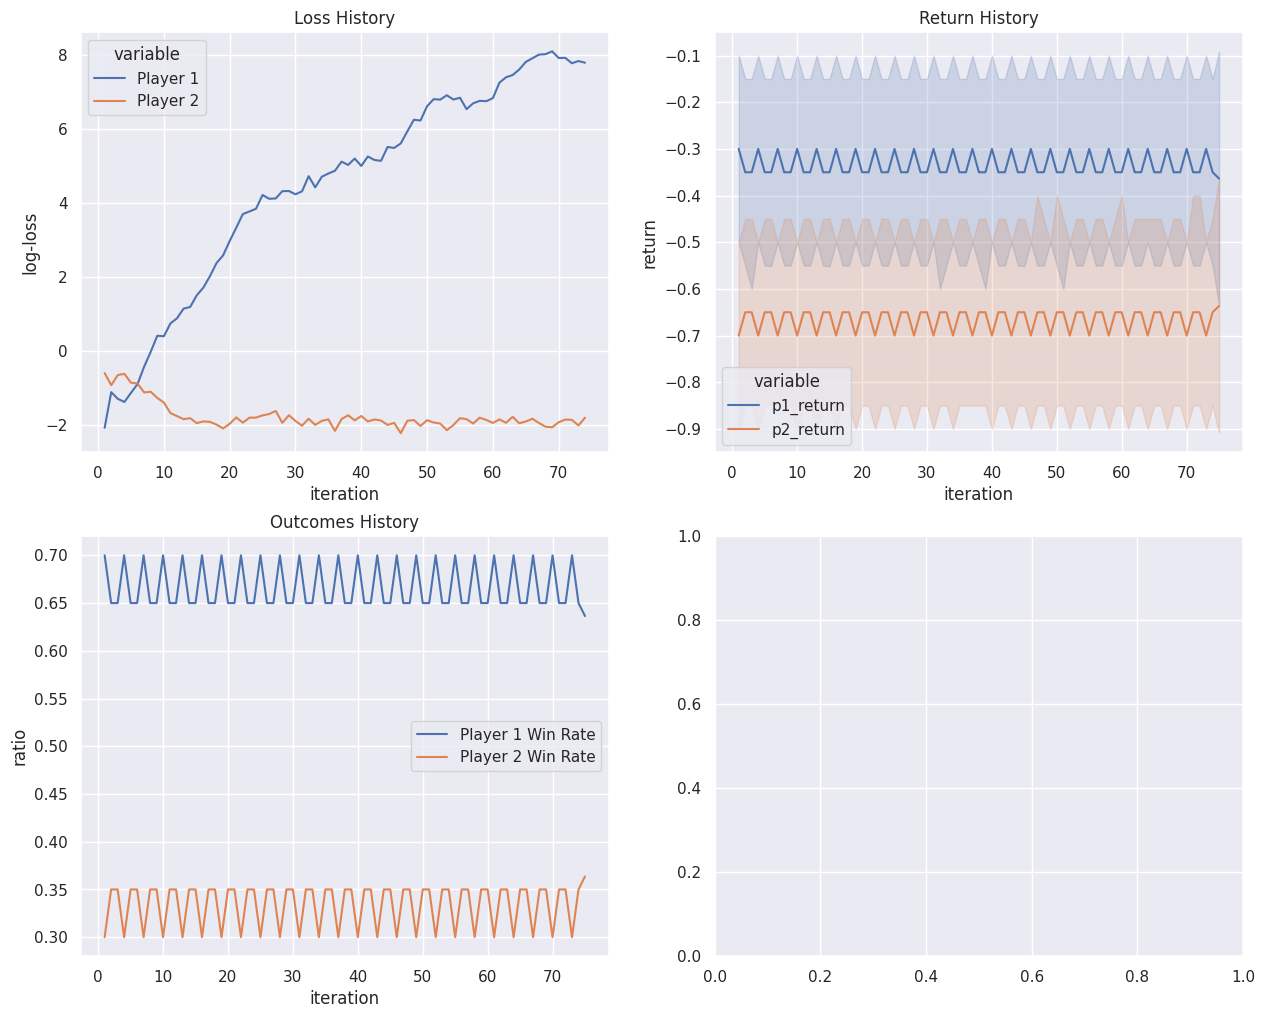

In [ ]:
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
checkpoint_dir = './checkpoints_basic'
checkpoint_dir_1 = os.path.join(checkpoint_dir, "ckpt1")
checkpoint_dir_2 = os.path.join(checkpoint_dir, "ckpt2")

def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return = player_2.episode_return()

        if p1_return == WhoAmIMultiAgentEnv.REWARD_WIN or p2_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p1_win'
        elif p2_return == WhoAmIMultiAgentEnv.REWARD_WIN or p1_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p2_win'
        else:
            outcome = 'draw'

        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step(),
            'seq_questions': tf_ttt_env.envs[0].get_seq_questions()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()

        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

        # Backup checkpoints
        train_checkpointer_1.save(global_step)
        train_checkpointer_2.save(global_step)

def plot_history():
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)

    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')

    plt.show()

# Fix hyperparameters
num_iterations = 2000
initial_collect_episodes = 100
episodes_per_iteration = 20
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50

iteration = 1
games = []
loss_infos = []

log = False

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

global_step = tf.compat.v1.train.get_or_create_global_step()

train_checkpointer_1 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_1,
            max_to_keep=1,
            agent=player_1,
            policy=player_1.policy,
            replay_buffer=player_1.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_1.initialize_or_restore()

train_checkpointer_2 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_2,
            max_to_keep=1,
            agent=player_2,
            policy=player_2.policy,
            replay_buffer=player_2.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_2.initialize_or_restore()

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()

On voit que les courbes sont bornées par les contraintes de l'environnement dans des "tunnels" liés à l'environnement fortement contraint.

Selon le tirage de la 1er question (cf. ci-dessous), on peut voir des résultats différents : soit une tendance à l'équité entre les 2 joueurs (enveloppe de gain proche de 0) ou au contraire des îlots séparés pour les 2 joueurs. L'enveloppe de gain est également variable et peut être comprise entre +0.2 et -0.8 et une moyenne entre -0.1 et -0.2 selon les tirages (les résultats ci-dessous peuvent évoluer selon les tirages).

On constate dans certaine exécution qu'une partition peut apparaître entre le comportement des résultats du joueur 1 et du joueur 2. Ici les résultats d'un joueur peuvent être meilleurs que ceux de l'autre joueur ou non (par exemple, 70% pour un jeur, 30% pour l'autre). Comment l'expliquer ?

Cela peut s'expliquer par le choix aléatoire du personnage à trouver et par la répartition aléatoire des questions entre les 2 joueurs (cf. questions initiales définies par défaut dans l'environnement) qui n'est pas forcément homogène vis-à-vis du "niveau d'élimination de la question dans le jeu" c'est-à-dire que des questions sont davantages susceptibles de réaliser une plus forte élimination dans l'ensemble des personnage que d'autres (par exemple, "Est-ce que c'est un homme ?"). Poser ce type de question donne donc un avantage.

L'utilisation d'un agent permet donc de vérifier ce type d'hypothèse et d'autres hypothèses qu'on pourrait faire sur le choix des questions.

Nous avons laissé volontairement ce léger biais des conditions initiales entre les 2 joueurs pour montrer l'importance des données et, pour notre cas, de la première question posée. Vous pouvez ajuster facilement la première question dans l'environnement pour supprimer ce biais si vous le souhaitez.

Dans l'absolu, il faudrait entraîner le modèle avec le plus de configurations différentes possible (avec ou sans biais).

Si vous voulez sauver le point d'arrêt de l'entraînement :

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p "$PATH_TO_MODEL"
!cp -r checkpoints_basic "$PATH_TO_MODEL"

Mounted at /content/drive


**2.4. Analyse des séquences de question**

Et qu'en est-il donc des séquences de question ?

Grâce à la mise en place du jeu, nous pouvons examiner plus en détails les séquences de questions en utilisants par exemple les résultats de l'entraînement sur notre ensemble de données.

Pour cela, regardons les séquences de question correspondant aux parties gagnées et les schémas de séquences de question identiques associés.

In [ ]:
import pandas as pd
import numpy as np

# Convert the games list to a Pandas DataFrame
df = pd.DataFrame(games)

# Filter the DataFrame to get games where outcome is 'p1_win'
filtered_df = df[df['outcome'] == 'p1_win']

# Check if there are any games with 'p1_win' outcome
if not filtered_df.empty:
    # Extract the seq_questions for the first player only
    array_seq = filtered_df['seq_questions'].iloc[0]
    # Display the sequence associated
    print('Optimal sequences of questions:')
    for i in range(len(array_seq)):
      print("* Seq " + str(i+1) + ":")
      print(" Size:" + str(len(array_seq[i])))
      for n in array_seq[i]:
        print(" - " + question_list[n])
else:
    print("No games with 'p1_win' outcome found.")

# Unique patterns found
unq, counts = np.unique(array_seq, return_counts=True)
ind = np.argsort(counts)[::-1]
unq = unq[ind]
counts = counts[ind]
print()
print('Patterns found:')
k = 0
for n in unq[counts > 1]:
  print("- " + question_list[n] + " ( count = " + str(counts[k]) + " )")
  k = k + 1


Optimal sequences of questions:
* Seq 1:
 Size:7
 - Does he have long hair?
 - Does he have a clear complexion?
 - Does he have a medium size?
 - Does he have a bow-shaped mouth?
 - Is he thin?
 - Does he have white skin?
 - Does he have a diamond face?
* Seq 2:
 Size:7
 - Does he have long hair?
 - Does he have a long dress?
 - Does he have a scarf?
 - Does he have brown eyes?
 - Does he have a black beard?
 - Does he have glasses?
 - Does he have short pants?

Patterns found:
- Does he have long hair? ( count = 2 )


On obtient des sequences de questions optimum de taille 7 avec une récurrence sur une question. Cela signifie-t-il qu'il faut 7 questions en moyenne pour gagner ?

Bien-sûr, si nous voulions généraliser ce type de résultats hors du cadre de notre exemple, il nous faudrait faire l'exercice sur un volume et une variété de données beaucoup plus important.

Nous n'avons fait qu'effleurer ici le sujet. Quels types de question sont meilleurs que d'autres ? Pourrions-nous associer des poids aux questions ? Quel est l'influence du pourcentage d'erreur (ou de mensonge) ? ...   

**2.5. Evaluation du modèle**

Maintenant que le modèle est suffisamment entraîné, voyons comment il se comporte.

Le joueur 1 commence :

In [ ]:
from itertools import cycle

ts = tf_ttt_env.reset()
# arbitrary starting point to add variety
random.seed(1)
log=True
# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
  selected_item[1] = random.choice(range(nb_person))
player_1.reset()
player_2.reset()
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None
print('Start board:')
print_whoami(ts.observation[0].numpy())
players = cycle([player_1, player_2])
while not ts.is_last():
    player = next(players)
    player_id = 1 if player == player_1 else 2
    other_player_id = 1 + player_id % 2
    action_dict = tf_ttt_env.envs[0].get_current_action()
    player.act()
    ts = tf_ttt_env.current_time_step()
    print('Player:', {player.name}, '\n',
          'Question of player:', question_list[action_dict['question'][player_id-1]], '\n',
          'Answer of other player:', yesno(action_dict['answer'][other_player_id-1]), '\n',
          'Question of other player:', question_list[action_dict['question'][other_player_id-1]], '\n',
          'Answer of player:', yesno(action_dict['answer'][player_id-1]), '\n',
          'Reward:', ts.reward[0].numpy(), 'Board:')
    print_whoami(ts.observation[0].numpy())
    print_seq_questions(tf_ttt_env.envs[0].get_seq_questions())

Start board:
Player 1 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player: {'Player1'} 
 Question of player: Does he have an oval face? 
 Answer of other player: no 
 Question of other player: Is he thin? 
 Answer of player: yes 
 Reward: 0.0 Board:
Player 1 :
? | ? | ? | ? | X | X | ? | ? | ? | ? | ? | ? | ? | ? | ? | ? | ? | ? | ? | ?
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | X |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Sequence of questions:
Player 1 :
- Does he have an oval face?
Player 2 :
- Is he thin?
Player: {'Player2'} 
 Question of player: Do

Le joueur 1 a-t-il gagné ? Vérifiez que c'est un peu mieux qu'avant la phase d'entraînement.

Le joueur 2 commence :

In [ ]:
from itertools import cycle

ts = tf_ttt_env.reset()
# arbitrary starting point to add variety
random.seed(1)
log=True
# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
  selected_item[1] = random.choice(range(nb_person))
player_1.reset()
player_2.reset()
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None
print('Start:')
print_whoami(ts.observation[0].numpy())
players = cycle([player_2, player_1])
while not ts.is_last():
    player = next(players)
    player_id = 1 if player == player_1 else 2
    other_player_id = 1 + player_id % 2
    action_dict = tf_ttt_env.envs[0].get_current_action()
    player.act()
    ts = tf_ttt_env.current_time_step()
    print('Player:', {player.name}, '\n',
          'Question of player:', question_list[action_dict['question'][player_id-1]], '\n',
          'Answer of other player:', yesno(action_dict['answer'][other_player_id-1]), '\n',
          'Question of other player:', question_list[action_dict['question'][other_player_id-1]], '\n',
          'Answer of player:', yesno(action_dict['answer'][player_id-1]), '\n',
          'Reward:', ts.reward[0].numpy(), 'Board:')
    print_whoami(ts.observation[0].numpy())
    print_seq_questions(tf_ttt_env.envs[0].get_seq_questions())

Start:
Player 1 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player: {'Player2'} 
 Question of player: Does he have a brown beard? 
 Answer of other player: no 
 Question of other player: Does he have brown hair? 
 Answer of player: no 
 Reward: 0.0 Board:
Player 1 :
  |   |   |   | X |   |   |   |   |   |   |   |   |   |   |   |   |   |   |  
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Player 2 :
? | ? | X | X | X | ? | ? | ? | X | X | X | X | ? | ? | ? | X | X | X | X | ?
- + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + - + -

Sequence of questions:
Player 1 :
- Does he have brown hair?
Player 2 :
- Does he have a brown beard?
Player: {'Player1'} 
 Q

A-t-on gagné ?

Ce qui est intéressant ici, c'est de noter comment les joueurs gagnent ou perdent et en particulier la séquence de questions qu'ils ont posé pour gagner / perdre : Est-elle plus rapide en moyenne ? A quelles séquences de questions correspondent-t-elle ?

In [ ]:
log=False
compute_avg_return(tf_ttt_env, player_1, 100)

Vous devriez observer que les résultats sont légèrement meilleurs pour un joueur (Gain faible de l'ordre de 20%).

Bien-sûr, pour exploiter et généraliser les résultats, il faudrait faire l'exercice sur un volume beaucoup plus important et plus variés de données que ceux présentés ici (questions et images nombreuses et variées).

Cependant, si ils sont vérifiés, ces résultats pourraient être exploités dans un cadre plus large que celui du jeu lui-même afin de déterminer le plus rapidement possible une personne dans un groupe de manière indirecte par exemple.

Et si vous jouiez vous-même une partie contre un agent ?

Lorsque c'est votre tour, choisissez une question parmi la liste des questions disponibles pour essayer de trouver le personnage de votre adversaire (l'agent) avant qu'il ne découvre le votre !

Un petit bout de code pour utiliser un widget de sélection des questions.

In [ ]:
!pip install jupyter_ui_poll

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from jupyter_ui_poll import ui_events
import time
from IPython.display import display

r_question_list = list(question_list)
selected_question_by_player = None
clicked = False

select_list = widgets.Select(
    options=r_question_list,
    value=r_question_list[0],
    layout={'width': 'max-content'},
    rows=20,
    description='Select:',
    disabled=False
)
button = widgets.Button(
    description='Click to confirm',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Select a question to find the person of other player',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
output = widgets.Output()
question_selector = widgets.Box([ select_list , button, output ])

def on_button_clicked(b):
  global clicked, selected_question_by_player
  with output:
      output.clear_output()
      clicked=True
      print('You have selected:')
      print(select_list.value)
      selected_question_by_player = select_list.value
      # Update the widget
      if selected_question_by_player in r_question_list: # Check if the value exists
          r_question_list.remove(select_list.value)
      select_list.options = r_question_list
      select_list.value = r_question_list[0] if r_question_list else None # Handle empty list

button.on_click(on_button_clicked)

def wait_click():
  global clicked
  with ui_events() as poll:
    while not clicked:
        poll(10) # poll queued UI events including button
        time.sleep(1) # wait for 1 second before checking again
  clicked=False


puis le code démarrer la partie (vous êtes le joueur 1).

Vous devez sélectionner votre question à chaque tour.

Vous pouvez interrompre la partie si vous le souhaitez en arrêtant la session de la cellule.

In [ ]:
from itertools import cycle

ts = tf_ttt_env.reset()
# arbitrary starting point to add variety
random.seed(1)
log=True
# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
  selected_item[1] = random.choice(range(nb_person))
player_1.reset()
player_2.reset()
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None
print('Start board:')
print_whoami(ts.observation[0].numpy())
# Player 1 begin for example
players = cycle([player_1, player_2])

try:

  while not ts.is_last():
    player = next(players)
    player_id = 1 if player == player_1 else 2
    other_player_id = 1 + player_id % 2
    action_dict = tf_ttt_env.envs[0].get_current_action()
    # User shall choose the questions
    output.clear_output()
    display(question_selector)
    wait_click()
    # Define the question to use
    selected_question_id_for_player_1 = question_list.index(selected_question_by_player)
    # User will be player 1
    if player_id == 1:
      action_dict['question'][player_id-1] = selected_question_id_for_player_1
    else:
      action_dict['question'][other_player_id-1] = selected_question_id_for_player_1

    player.act()
    ts = tf_ttt_env.current_time_step()
    print('Player:', {player.name}, '\n',
          'Question of player:', question_list[action_dict['question'][player_id-1]], '\n',
          'Answer of other player:', yesno(action_dict['answer'][other_player_id-1]), '\n',
          'Question of other player:', question_list[action_dict['question'][other_player_id-1]], '\n',
          'Answer of player:', yesno(action_dict['answer'][player_id-1]), '\n',
          'Reward:', ts.reward[0].numpy(), 'Board:')
    print_whoami(ts.observation[0].numpy())
    print_seq_questions(tf_ttt_env.envs[0].get_seq_questions())
    print('Your board:')
    id_person_deleted_1 = tf_ttt_env.envs[0].get_deleted_items()
    for i in range(len(id_person_deleted_1)):
      id_person_deleted_1[i] = id_person_deleted_1[i][0]
    display_board(id_person_deleted_1)

except KeyboardInterrupt:
    print('Interrupted by user...')


Output hidden; open in https://colab.research.google.com to view.

Les personnage du tableau de bord simplifié suivent une lecture de gauche à droite et dans le tableau de bord sous forme d'images c'est de gauche à droite avec retour à la ligne de haut en bas.

Notez que vous êtes limité à l'ensemble des questions et des personnages disponibles ici.

**2.6. Pour aller plus loin**

Nous n'avons traité que le cas simple : Le cas où nous avons uniquement les personnages issues d'une image et une liste de questions pré-déterminées. Mais il serait intéressant d'étendre le sujet à d'autres personnages et d'autres questions non préalablement connus.

Pour cela, nous allons partir d'un ensemble de données "plus orienté sur les personnes réelles", celui du deuxième dictionnaire (Il faudrait sans doute encore beaucoup plus de données mais cela suffira pour expliquer le principe).

In [25]:
dict_person = []

# load the dictionnary
import numpy as np
with open('extended_dict_person.npy', 'rb') as f:
    dict_person = np.load(f, allow_pickle=True)

question_list = get_available_questions(0)
# A sample of partition of questions between two player
question_list_for_player_1 = question_list[:len(question_list)//2]
question_list_for_player_2 = question_list[len(question_list)//2:]

nb_person = get_nb_person()
nb_question = len(question_list)

print("nb_question = ")
print(nb_question)

print("nb_person = ")
print(nb_person)

nb_question = 
60
nb_person = 
14


Il nous faut refaire l'apprentissage avec ce jeux de données plus important.

De prime abord, cela ne nous permettra pas pour autant de pouvoir a priori poser une nouvelle question ou essayer de l'appliquer à une autre image que celles déjà disponibles.

Nous avons fait plusieurs tests : injection des actions par l'environnement, puis injection des actions mixte (environnement et politique aléatoire du réseau DQN), puis injection des actions par politique aléatoire du réseau DQN.

Interrupting training, plotting history...


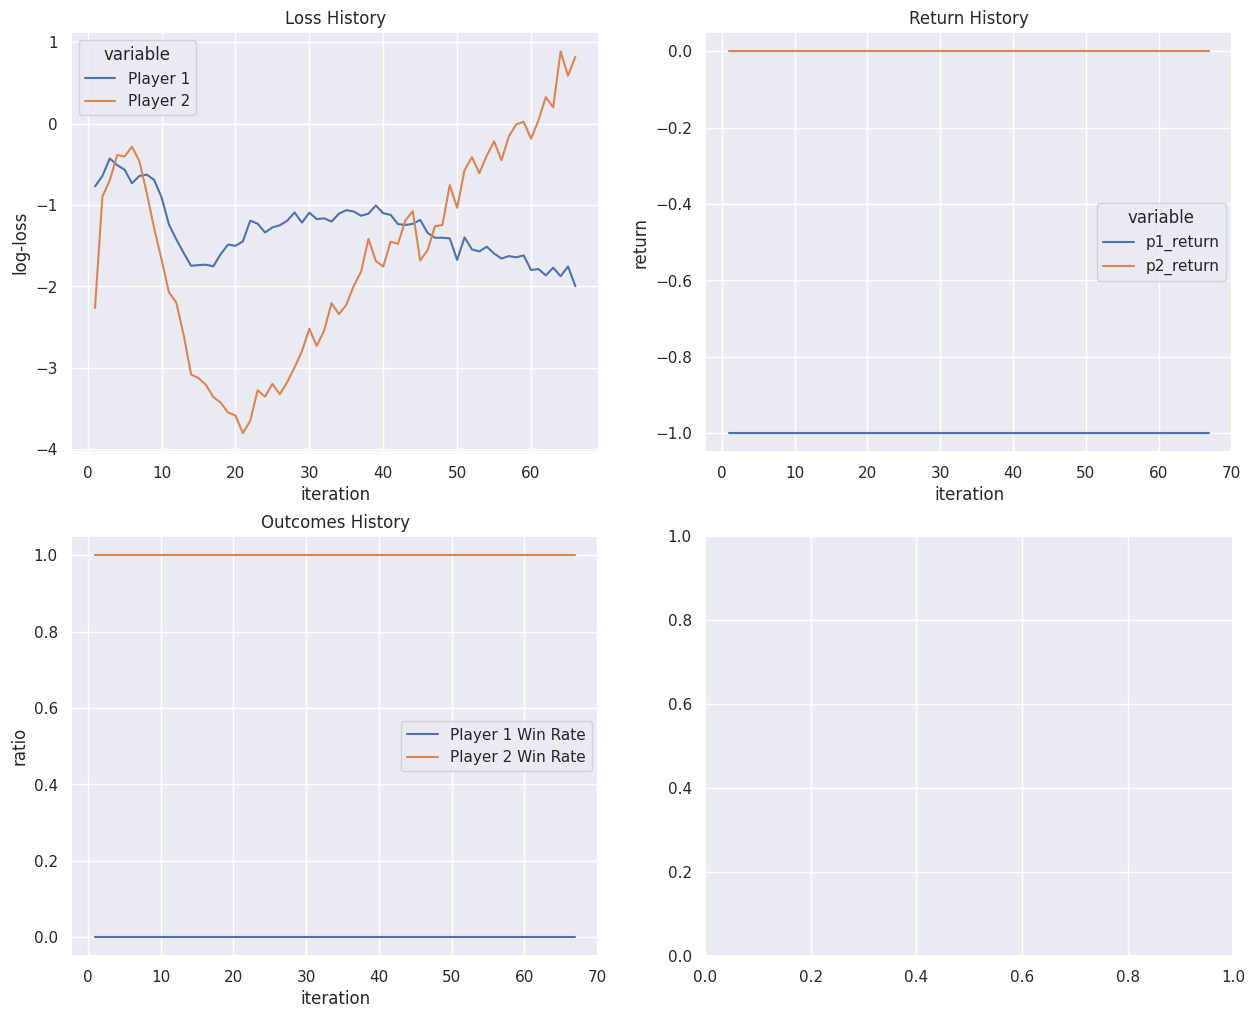

In [ ]:
from itertools import cycle
from functools import partial
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
checkpoint_dir = './checkpoints_extended'
checkpoint_dir_1 = os.path.join(checkpoint_dir, "ckpt1")
checkpoint_dir_2 = os.path.join(checkpoint_dir, "ckpt2")

# Fix hyperparameters
num_iterations = 2000
initial_collect_episodes = 100
episodes_per_iteration = 20
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50

log = False

iteration = 1
games = []
loss_infos = []

whoami_env = WhoAmIMultiAgentEnv()

tf_ttt_env = TFPyEnvironment(whoami_env)

random.seed(1)

# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
    selected_item[1] = random.choice(range(nb_person))

# Used to manual definition only
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None

def ttt_action_fn(player, action_step):
    """
    Converts a scalar action_step to a dictionary of actions for the environment.

    Args:
        player: The player (1 or 2).
        action_step: The scalar action.

    Returns:
        A dictionary of actions.
    """

    # Uncomment here if you want control the questions also use environment controlled
    ## Convert action to a NumPy array or a Python integer if it's a Tensor
    #action_step = action_step.numpy() if tf.is_tensor(action_step) else action_step
    ## If action_step is still an array (e.g., shape (1,)), get the scalar value
    #if isinstance(action_step, np.ndarray) and action_step.shape == (1,):
    #    action_step = action_step.item()

    # Extract the individual action components from the scalar action_step using divmod
    #question1, question2 = divmod(action_step, nb_question)

    # Position is environment controlled so we don't use 'action_step' as position.
    current_action_dict = tf_ttt_env.envs[0].get_current_action()
    if current_action_dict != None:
      question1_id = current_action_dict['question'][0]
      question2_id = current_action_dict['question'][1]
    else:
      # First question only (internal injection)
      question1_id = question_list.index(random.choice(question_list_for_player_1))
      question2_id = question_list.index(random.choice(question_list_for_player_2))

    # Only if we want define user question
    if selected_question_id_for_player_1 != None:
        question1_id = selected_question_id_for_player_1
    if selected_question_id_for_player_2 != None:
        question2_id = selected_question_id_for_player_2

    # Create the dictionary of actions
    # Note: selected_item is computed as an initial condition
    action_dict = {
       'selected_item': tf.convert_to_tensor(np.array([selected_item]), dtype=tf.int32),
       'question': tf.convert_to_tensor(np.array([[question1_id, question2_id]]), dtype=tf.int32),
       'answer': tf.convert_to_tensor(np.array([[0, 0]]), dtype=tf.int32), # Always redefined by environment
       'player': tf.convert_to_tensor(np.array([player]), dtype=tf.int32)
    }

    return action_dict

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

# Training episode
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    # arbitrary starting point to add variety
    random.seed(1)
    # Selected item is an initial condition
    selected_item = np.array([0, 0])
    selected_item[0] = random.choice(range(nb_person))
    selected_item[1] = selected_item[0]
    while selected_item[0] == selected_item[1]:
      selected_item[1] = random.choice(range(nb_person))
    player_1.reset()
    player_2.reset()
    selected_question_id_for_player_1 = None
    selected_question_id_for_player_2 = None
    time_steps = []
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()
        time_steps.append(ts)
    return time_steps

def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return = player_2.episode_return()

        if p1_return == WhoAmIMultiAgentEnv.REWARD_WIN or p2_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p1_win'
        elif p2_return == WhoAmIMultiAgentEnv.REWARD_WIN or p1_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p2_win'
        else:
            outcome = 'draw'

        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step(),
            'seq_questions': tf_ttt_env.envs[0].get_seq_questions()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()

        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

        # Backup checkpoints
        train_checkpointer_1.save(global_step)
        train_checkpointer_2.save(global_step)

def plot_history():
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)

    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')

    plt.show()

# The number of steps is limited by the number of questions
nb_action_max = nb_question

action_spec = BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0., maximum=nb_action_max-1, name='action')

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

global_step = tf.compat.v1.train.get_or_create_global_step()

train_checkpointer_1 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_1,
            max_to_keep=1,
            agent=player_1,
            policy=player_1.policy,
            replay_buffer=player_1.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_1.initialize_or_restore()

train_checkpointer_2 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_2,
            max_to_keep=1,
            agent=player_2,
            policy=player_2.policy,
            replay_buffer=player_2.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_2.initialize_or_restore()

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()

Interrupting training, plotting history...


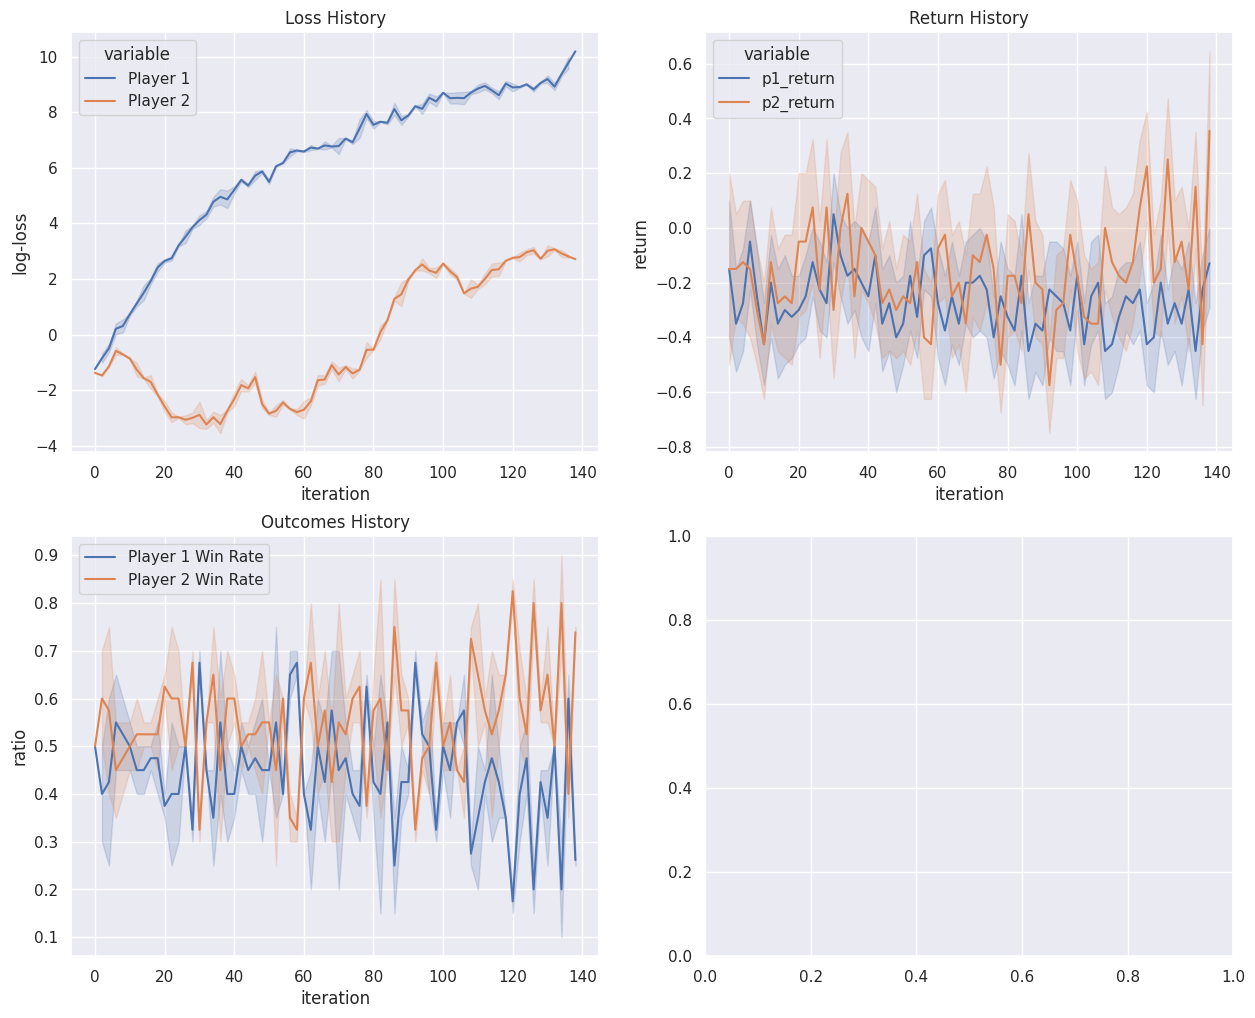

In [27]:
from itertools import cycle
from functools import partial
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
checkpoint_dir = './checkpoints_extended_2'
checkpoint_dir_1 = os.path.join(checkpoint_dir, "ckpt1")
checkpoint_dir_2 = os.path.join(checkpoint_dir, "ckpt2")

# Fix hyperparameters
num_iterations = 2000
initial_collect_episodes = 100
episodes_per_iteration = 20
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50

log = False

iteration = 1
games = []
loss_infos = []

random.seed(1)

# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
    selected_item[1] = random.choice(range(nb_person))

# Used to manual definition only
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None

whoami_env = WhoAmIMultiAgentEnv()

ts = whoami_env.reset()

# Player 1 begin
player = 1

# First question only is computed by environment (external injection)
q_gen_1 = question_list.index(random.choice(question_list_for_player_1))
q_gen_2 = question_list.index(random.choice(question_list_for_player_2))
action = {
      'selected_item': selected_item,
      'question': np.array([ q_gen_1, q_gen_2 ]),
      'answer': np.array([ 0, 0 ]), # Always redefined by environment
      'player': player
    }

ts = whoami_env.step(action)

tf_ttt_env = TFPyEnvironment(whoami_env)

def ttt_action_fn(player, action_step):
    """
    Converts a scalar action_step to a dictionary of actions for the environment.

    Args:
        player: The player (1 or 2).
        action_step: The scalar action.

    Returns:
        A dictionary of actions.
    """

    # Uncomment here if you want control the questions also use environment controlled
    # Convert action to a NumPy array or a Python integer if it's a Tensor
    action_step = action_step.numpy() if tf.is_tensor(action_step) else action_step
    # If action_step is still an array (e.g., shape (1,)), get the scalar value
    if isinstance(action_step, np.ndarray) and action_step.shape == (1,):
        action_step = action_step.item()

    # Return also the question from environment
    current_action_dict = tf_ttt_env.envs[0].get_current_action()
    question1_id = current_action_dict['question'][0]
    question2_id = current_action_dict['question'][1]

    # Try to override with use action_step to choose a question per player
    if player == 1:
      question1_id = action_step
    else:
      question2_id = action_step

    # Only if we want define user question
    if selected_question_id_for_player_1 != None:
        question1_id = selected_question_id_for_player_1
    if selected_question_id_for_player_2 != None:
        question2_id = selected_question_id_for_player_2

    # Create the dictionary of actions
    # Note: selected_item is computed as an initial condition
    action_dict = {
       'selected_item': tf.convert_to_tensor(np.array([selected_item]), dtype=tf.int32),
       'question': tf.convert_to_tensor(np.array([[question1_id, question2_id]]), dtype=tf.int32),
       'answer': tf.convert_to_tensor(np.array([[0, 0]]), dtype=tf.int32), # Always redefined by environment
       'player': tf.convert_to_tensor(np.array([player]), dtype=tf.int32)
    }

    return action_dict

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

# Training episode
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    # arbitrary starting point to add variety
    random.seed(1)
    # Selected item is an initial condition
    selected_item = np.array([0, 0])
    selected_item[0] = random.choice(range(nb_person))
    selected_item[1] = selected_item[0]
    while selected_item[0] == selected_item[1]:
      selected_item[1] = random.choice(range(nb_person))
    player_1.reset()
    player_2.reset()
    selected_question_id_for_player_1 = None
    selected_question_id_for_player_2 = None
    time_steps = []
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()
        time_steps.append(ts)
    return time_steps

def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return = player_2.episode_return()

        if p1_return == WhoAmIMultiAgentEnv.REWARD_WIN or p2_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p1_win'
        elif p2_return == WhoAmIMultiAgentEnv.REWARD_WIN or p1_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p2_win'
        else:
            outcome = 'draw'

        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step(),
            'seq_questions': tf_ttt_env.envs[0].get_seq_questions()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()

        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

        # Backup checkpoints
        train_checkpointer_1.save(global_step)
        train_checkpointer_2.save(global_step)

def plot_history():
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)

    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')

    plt.show()

# The number of steps is limited by the number of questions
nb_action_max = nb_question

action_spec = BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0., maximum=nb_action_max-1, name='action')

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

global_step = tf.compat.v1.train.get_or_create_global_step()

train_checkpointer_1 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_1,
            max_to_keep=1,
            agent=player_1,
            policy=player_1.policy,
            replay_buffer=player_1.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_1.initialize_or_restore()

train_checkpointer_2 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_2,
            max_to_keep=1,
            agent=player_2,
            policy=player_2.policy,
            replay_buffer=player_2.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_2.initialize_or_restore()

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()

Interrupting training, plotting history...


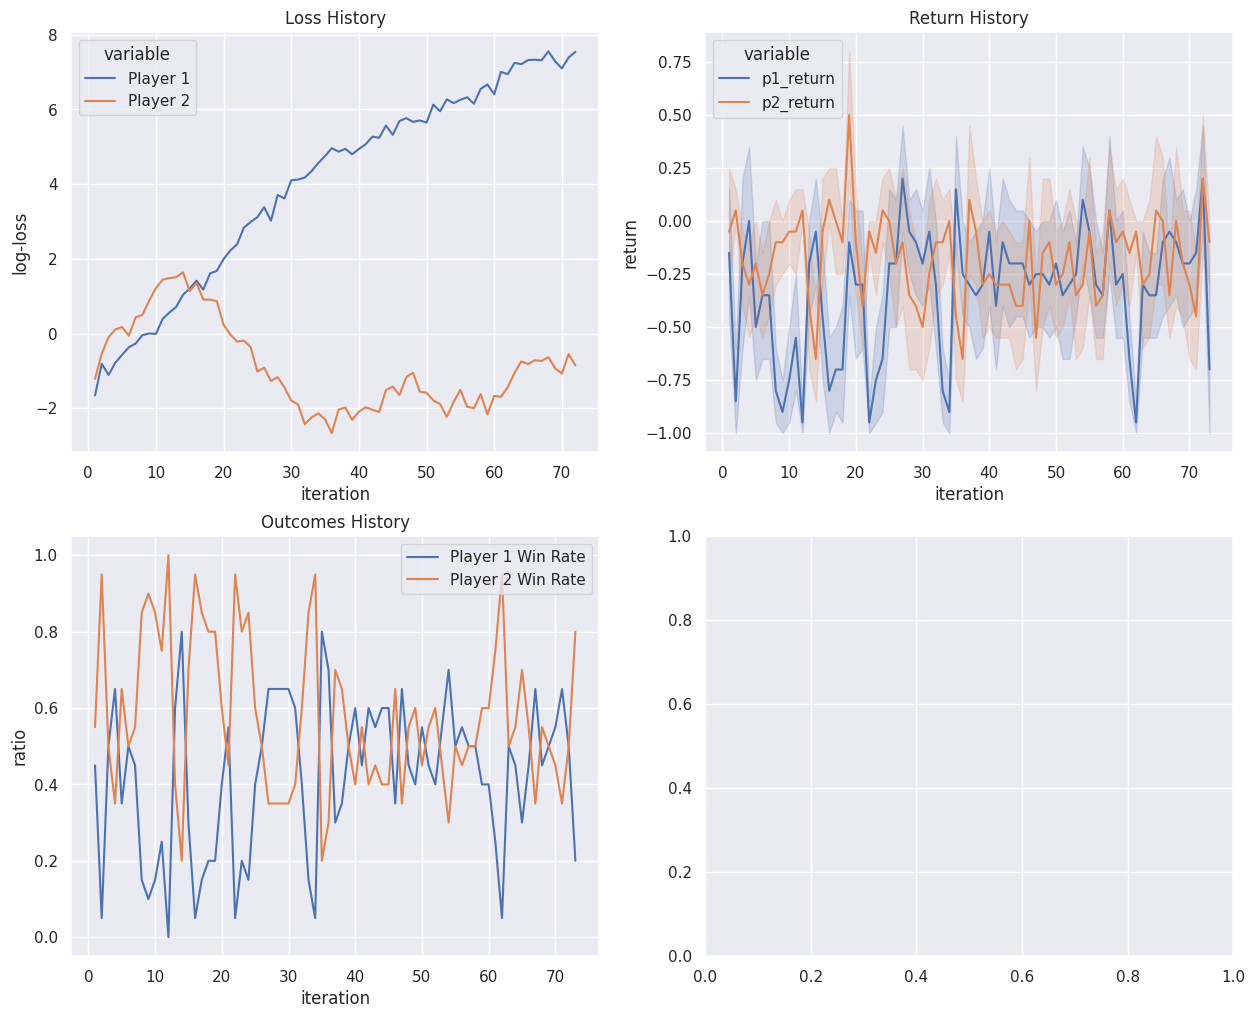

In [30]:
from itertools import cycle
from functools import partial
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import os
checkpoint_dir = './checkpoints_extended_3'
checkpoint_dir_1 = os.path.join(checkpoint_dir, "ckpt1")
checkpoint_dir_2 = os.path.join(checkpoint_dir, "ckpt2")

# Fix hyperparameters
num_iterations = 2000
initial_collect_episodes = 100
episodes_per_iteration = 20
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 3 * episodes_per_iteration * 9
learning_rate = 1e-2
plot_interval = 50

log = False

iteration = 1
games = []
loss_infos = []

random.seed(1)

# Selected item is an initial condition
selected_item = np.array([0, 0])
selected_item[0] = random.choice(range(nb_person))
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
    selected_item[1] = random.choice(range(nb_person))

# Used to manual definition only
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None

whoami_env = WhoAmIMultiAgentEnv()

ts = whoami_env.reset()

# Player 1 begin
player = 1

# First question only is computed by environment (external injection)
q_gen_1 = question_list.index(random.choice(question_list_for_player_1))
q_gen_2 = question_list.index(random.choice(question_list_for_player_2))
action = {
      'selected_item': selected_item,
      'question': np.array([ q_gen_1, q_gen_2 ]),
      'answer': np.array([ 0, 0 ]), # Always redefined by environment
      'player': player
    }

ts = whoami_env.step(action)

tf_ttt_env = TFPyEnvironment(whoami_env)

def ttt_action_fn(player, action_step):
    """
    Converts a scalar action_step to a dictionary of actions for the environment.

    Args:
        player: The player (1 or 2).
        action_step: The scalar action.

    Returns:
        A dictionary of actions.
    """

    # Uncomment here if you want control the questions also use environment controlled
    # Convert action to a NumPy array or a Python integer if it's a Tensor
    action_step = action_step.numpy() if tf.is_tensor(action_step) else action_step
    # If action_step is still an array (e.g., shape (1,)), get the scalar value
    if isinstance(action_step, np.ndarray) and action_step.shape == (1,):
        action_step = action_step.item()

    # Extract the individual action components from the scalar action_step using divmod
    question1_id, question2_id = divmod(action_step, nb_question)

    # Comment here because we don't use the question from environment
    #current_action_dict = tf_ttt_env.envs[0].get_current_action()
    #question1_id = current_action_dict['question'][0]
    #question2_id = current_action_dict['question'][1]

    # Only if we want define user question
    if selected_question_id_for_player_1 != None:
        question1_id = selected_question_id_for_player_1
    if selected_question_id_for_player_2 != None:
        question2_id = selected_question_id_for_player_2

    # Create the dictionary of actions
    # Note: selected_item is computed as an initial condition
    action_dict = {
       'selected_item': tf.convert_to_tensor(np.array([selected_item]), dtype=tf.int32),
       'question': tf.convert_to_tensor(np.array([[question1_id, question2_id]]), dtype=tf.int32),
       'answer': tf.convert_to_tensor(np.array([[0, 0]]), dtype=tf.int32), # Always redefined by environment
       'player': tf.convert_to_tensor(np.array([player]), dtype=tf.int32)
    }

    return action_dict

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

# Training episode
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    # arbitrary starting point to add variety
    random.seed(1)
    # Selected item is an initial condition
    selected_item = np.array([0, 0])
    selected_item[0] = random.choice(range(nb_person))
    selected_item[1] = selected_item[0]
    while selected_item[0] == selected_item[1]:
      selected_item[1] = random.choice(range(nb_person))
    player_1.reset()
    player_2.reset()
    selected_question_id_for_player_1 = None
    selected_question_id_for_player_2 = None
    time_steps = []
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()
        time_steps.append(ts)
    return time_steps

def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return = player_2.episode_return()

        if p1_return == WhoAmIMultiAgentEnv.REWARD_WIN or p2_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p1_win'
        elif p2_return == WhoAmIMultiAgentEnv.REWARD_WIN or p1_return == WhoAmIMultiAgentEnv.REWARD_LOSS:
            outcome = 'p2_win'
        else:
            outcome = 'draw'

        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step(),
            'seq_questions': tf_ttt_env.envs[0].get_seq_questions()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()

        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

        # Backup checkpoints
        train_checkpointer_1.save(global_step)
        train_checkpointer_2.save(global_step)

def plot_history():
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)

    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')

    plt.show()

# The number of steps is limited by the number of questions
# Here, we have the questions for the two players
nb_action_max = nb_question * nb_question

action_spec = BoundedTensorSpec(
        shape=(), dtype=tf.int32, minimum=0., maximum=nb_action_max-1, name='action')

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = action_spec,
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

global_step = tf.compat.v1.train.get_or_create_global_step()

train_checkpointer_1 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_1,
            max_to_keep=1,
            agent=player_1,
            policy=player_1.policy,
            replay_buffer=player_1.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_1.initialize_or_restore()

train_checkpointer_2 = common.Checkpointer(
            ckpt_dir=checkpoint_dir_2,
            max_to_keep=1,
            agent=player_2,
            policy=player_2.policy,
            replay_buffer=player_2.get_replay_buffer(),
            global_step=global_step
        )

# Restore previous state if exist
train_checkpointer_2.initialize_or_restore()

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()

Trois types d'entraînement différents qui conduisent à des résultats assez différents à comparer (Nous vous laissons les comparer).

Pour sauver le modèle :

In [ ]:
from tf_agents.policies import policy_saver
import os

model_dir = './model_extended'
model_dir_1 = os.path.join(model_dir, "mdl1")
model_dir_2 = os.path.join(model_dir, "mdl2")
policy_saver.PolicySaver(player_1.policy).save(model_dir_1)
policy_saver.PolicySaver(player_2.policy).save(model_dir_2)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/usr/local/lib/python3.11/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p "$PATH_TO_MODEL"
!cp -r model_extended "$PATH_TO_MODEL"

Mounted at /content/drive


et le point d'arrêt de l'entraînement :

In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!mkdir -p "$PATH_TO_MODEL"
!cp -r checkpoints_extended* "$PATH_TO_MODEL"

Mounted at /content/drive


Pour que nous puissions utiliser ce modèle sur un jeu de données non appris, nous allons essayer une petite astuce.

Supposons que le joueur pose une question qui n'est pas dans la liste des questions connues, nous allons chercher la question "qui se rapproche le plus sémantiquement de la question posée" et qui est dans notre dictionnaire et essayer d'appliquer notre modèle sur celle-ci.

De même, supposons qu'on présente l'image d'un nouveau personnage qui n'est pas dans la liste des personnages connus, nous allons également chercher l'image "qui se rapproche le plus du personnage" et qui est dans notre dictionnaire et essayer d'appliquer le modèle dessus.

Pour cela, nous allons utiliser d'autres modèles déjà bien entraînés capables de mesurer les similarités (*cosine similarity*) entre deux images ou entre deux phrases.  

Pour les phrases, nous aurons besoin du module *sentence-transformers" avec le Transformer dédié.

In [34]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
  Atte

In [35]:
from sentence_transformers import SentenceTransformer, util

def sentence_with_max_similarity(s1, list_of_str):
  from sentence_transformers import SentenceTransformer, util
  model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
  e1 = model.encode(s1)
  e2 = model.encode(list_of_str)
  similarity = util.cos_sim(e1, e2)
  index_sim_max = np.argmax(similarity)
  return list_of_str[index_sim_max]

Pour les images, nous pouvons nous appuyer sur la mesure disponible par défaut dans Torch et sur le pipeline *image feature extraction* de Google.

In [36]:
from PIL import Image
from transformers import pipeline
from accelerate.test_utils.testing import get_backend
from torch.nn.functional import cosine_similarity
import torch

# automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
DEVICE, _, _ = get_backend()
pipe = pipeline(task="image-feature-extraction", model_name="google/vit-base-patch16-384", device=DEVICE, pool=True)

def image_with_max_similarity(image_real, list_of_images):
  similarity = []
  for img in list_of_images:
    outputs = pipe([image_real, img])
    similarity.append(float(cosine_similarity(torch.Tensor(outputs[0]), torch.Tensor(outputs[1]), dim=1)[0]))
  index_sim_max = np.argmax(similarity)
  return [ list_of_images[index_sim_max], index_sim_max, similarity[index_sim_max] ]

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda


Avec ces éléments, nous définissons deux fonctions pour trouver la question ou l'image la plus proche parmi les éléments disponibles.

In [37]:
def get_id_similar_question(question : str):
  s = sentence_with_max_similarity(question, question_list)
  if s in question_list:
    return question_list.index(s)
  return -1

Essayons sur une question simple :

In [ ]:
q_id = get_id_similar_question('Does he have a big mustache?')
if q_id == -1:
  print("Similar question not found.")
else:
  print("Similar question found: " + question_list[q_id])

Similar question found: Does he have a short mustache?


In [38]:
import numpy as np
from PIL import Image

# similarity min tolerance
sim_min_tol = 0.30

def get_id_similar_image(image : np.ndarray):
  # Convert the NumPy array to a PIL Image if needed
  if isinstance(image, np.ndarray):
    image = Image.fromarray(image)
  img_dict_person = []
  for i in range(len(dict_person)):
    img_dict_person.append(Image.fromarray(get_image_person(i)))
  near_img, id_dict_person, similarity = image_with_max_similarity(image, img_dict_person)
  #print("Similar image found: " + str(id_dict_person) + " with similarity: " + str(similarity))
  if similarity > sim_min_tol:
    return id_dict_person
  else:
    return -1

Etant donné le faible volume d'images de notre dictionnaire, nous nous contenterons d'une faible similarité (ajustable sur un dictionnaire plus important).

Essayons sur une image :

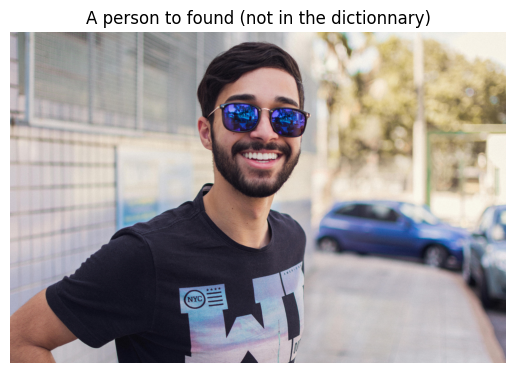

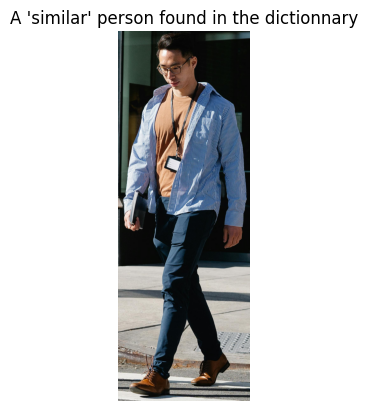

In [ ]:
from diffusers.utils import load_image
import matplotlib.pyplot as plt

image_src = load_image("https://images.pexels.com/photos/1212984/pexels-photo-1212984.jpeg")
plt.title('A person to found (not in the dictionnary)')
plt.imshow(image_src)
plt.axis('off')
plt.show()

p_id = get_id_similar_image(image_src)
if p_id == -1:
  print("Similar person not found.")
else:
  plt.title("A 'similar' person found in the dictionnary")
  plt.imshow(get_image_person(p_id))
  plt.axis('off')
  plt.show()

Bien-sûr ce n'est pas la même personne... C'est juste une lègère correspondance avec le faible nombre de personnes enregistrées dans le dictionnaire mais qui peutrépondre aux mêmes types de questions et donner le même type de réponse. La personne a la même couleur de cheveux, la même forme générale du visage, elle porte un tee-shirt et des lunettes également... mais il y a aussi des différences : pas de barbe...

Il s'agit juste d'un exemple pour illustrer le principe ici.  

Maintenant, nous n'avons plus qu'à essayer d'utiliser ce type de fonctions avec notre modèle.

In [ ]:
from itertools import cycle
from diffusers.utils import load_image
import matplotlib.pyplot as plt

ts = tf_ttt_env.reset()
player_1.reset()
player_2.reset()
print('Start:')
# arbitrary starting point to add variety
random.seed(1)
# Selected item is an initial condition
selected_item = np.array([0, 0])

# Suppose that you interest on a person
# Give me a person which isn't in the dictionnary
image_src = load_image("https://images.pexels.com/photos/1212984/pexels-photo-1212984.jpeg")
plt.title('A person to found (not in the dictionnary)')
plt.imshow(image_src)
plt.axis('off')
plt.show()
p_id = get_id_similar_image(image_src)
if p_id == -1:
  print("Similar image not found. Update your image and retry.")
  exit
# Player 2 shall found my person...
selected_item[0] = p_id
selected_item[1] = selected_item[0]
while selected_item[0] == selected_item[1]:
  selected_item[1] = random.choice(range(nb_person))
player_1.reset()
player_2.reset()
selected_question_id_for_player_1 = None
selected_question_id_for_player_2 = None
print('Start board:')
print_whoami(ts.observation[0].numpy())
# Player 1 begin for example
players = cycle([player_1, player_2])
list_q_id = []

try:

  while not ts.is_last():
    player = next(players)
    player_id = 1 if player == player_1 else 2
    other_player_id = 1 + player_id % 2
    action_dict = tf_ttt_env.envs[0].get_current_action()
    # User shall choose the questions
    while True:
        print('Give an english question to play here:')
        q = ''
        q = input()
        if q == '':
          print("No question given. Try again.")
        else:
          q_id = get_id_similar_question(q)
          if q_id == -1:
            print("Similar question not found. Try again.")
          else:
            # Question already given ?
            if q_id in list_q_id:
              print("Question already given. Try another question.")
            else:
              list_q_id.append(q_id)
              selected_question_id_for_player_1 = q_id
              break
    # User will be player 1
    if player_id == 1:
      action_dict['question'][player_id-1] = selected_question_id_for_player_1
    else:
      action_dict['question'][other_player_id-1] = selected_question_id_for_player_1

    player.act()
    ts = tf_ttt_env.current_time_step()
    print('Player:', {player.name}, '\n',
          'Question of player:', question_list[action_dict['question'][player_id-1]], '\n',
          'Answer of other player:', yesno(action_dict['answer'][other_player_id-1]), '\n',
          'Question of other player:', question_list[action_dict['question'][other_player_id-1]], '\n',
          'Answer of player:', yesno(action_dict['answer'][player_id-1]), '\n',
          'Reward:', ts.reward[0].numpy(), 'Board:')
    print_whoami(ts.observation[0].numpy())
    print_seq_questions(tf_ttt_env.envs[0].get_seq_questions())
    print('Your board:')
    id_person_deleted_1 = tf_ttt_env.envs[0].get_deleted_items()
    for i in range(len(id_person_deleted_1)):
      id_person_deleted_1[i] = id_person_deleted_1[i][0]
    display_board(id_person_deleted_1)

except KeyboardInterrupt:
    print('Interrupted by user...')


Pour être exploitable, cette approche doit toujours s'appuyer sur un large périmètre de questions et d'images pertinents mais demeure néamoins intéressante pour étendre le domaine d'application du modèle.

**3. Conclusion**

Nous avons vu que l'exploitation des réseaux de neurones doit permettre de jouer au jeu "Qui est-ce ?" et de trouver des résultats intéressants sur l'analyse des questions et des séquences de questions les plus appropriées pour ce jeu et, de manière plus générale, lorsqu'on est dans un processus de détermination d'une personne dans un collectif.

Bien-sûr, pour être applicable, le volume de données doit être beaucoup plus important et le modèle doit être entraîné largement sur ce volume de données.  